In [1]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.stats import pearsonr, f_oneway
from scipy.stats.contingency import association

# Constants Definition

In [2]:
datasets = [
    "adult",
    "german",
    "bank_marketing",
    "KDD_census",
    "ACS_I",
    "ACS_E",
    "ACS_P",
    "ACS_M",
    "ACS_T",
    "compas",
]


datasets_inter = [
    "adult",
    "german",
    "KDD_census",
    "ACS_I",
    "ACS_E",
    "ACS_P",
    "ACS_M",
    "ACS_T",
    "compas",
]


protected_attributes_dict = {
    "adult" : ["race", "sex",
               "sex_race"
               ],
    "german" : ["sex", "age",
                "sex_age"
                ],
    "bank_marketing" : ["age"],
    "KDD_census" : ["race", "sex",
                    "sex_race"
                    ],
    "ACS_I" : ["SEX", "RAC1P",
                "RAC1P_SEX"
                ],
    "ACS_E" : ["SEX", "RAC1P",
                "SEX_RAC1P"
                ],
    "ACS_P" : ["SEX", "RAC1P",
                "RAC1P_SEX"
                ],
    "ACS_M" : ["SEX", "RAC1P",
                "RAC1P_SEX"
                ],
    "ACS_T" : ["SEX", "RAC1P",
                "SEX_RAC1P"
                ],
    "compas" : ["race", "sex",
                "race_sex"
                ],
}


privileged_classes_inter_dict = {
    "adult": {"race_sex": "White_Male"},
    "german": {"sex_age": "male_x>25"},
    "KDD_census": {"race_sex": " White_ Male"},
    "ACS_I": {"SEX_RAC1P": "Male_White"},
    "ACS_E": {"SEX_RAC1P": "Male_White"},
    "ACS_P": {"SEX_RAC1P": "Male_White"},
    "ACS_M": {"SEX_RAC1P": "Male_White"},
    "ACS_T": {"SEX_RAC1P": "Male_White"},
    "compas": {"race_sex": "Caucasian_Male"},
}

utility_metrics = ["acc", "auc", "ap","prec", "rec", "f1"]
fairness_metrics = ["dpr", "dpdiff", "eoddsr","eoddsdiff", "miss_rate_ratio", "fall_out_ratio", "CBS_pred"]
unfair_datasets = ["adult","german","bank_marketing","KDD_census","compas"]
fair_datasets = ["ACS_E","ACS_M", "ACS_P", "ACS_T", "ACS_I"]
balancing_strategies = ["none", "balance_output", "balance_protected_attribute", "balance_output_for_attribute", "balance_all"]
sampling_methods = ["RandomOverSampler", "RandomUnderSampler", "SMOTENC"]

BENCHMARK_PATH = "./results/benchmark/"

BENCHMARK_COLUMNS = ["model", "dataset", "sampling", "mitigation", "mitigated_attribute", "attribute", "CBS", "balance_index", "RMSDIR", "RMSPMI", "diff_length", "diff_length_prop",
                     "acc", "auc", "ap", "prec", "rec", "f1", "dpdiff", "dpr", "eoddsdiff", "eoddsr", "miss_rate_ratio", "fall_out_ratio", "CBS_pred"]

ALL_METRICS = ["CBS", "balance_index", "RMSPMI", "RMSDIR", "acc", "auc", "ap", "prec", "rec", "f1", "dpdiff", "dpr", "eoddsdiff", "eoddsr", "miss_rate_ratio", "fall_out_ratio", "CBS_pred"]

# Data Loading Function Definition

In [3]:
def normalize(df) :
    norm_df = df.copy()
    norms = ["CBS", "balance_index", "RMSDIR", "RMSPMI", "acc", "auc", "ap", "prec", "rec", "f1", "dpdiff", "dpr", "eoddsdiff", "eoddsr", "miss_rate_ratio", "fall_out_ratio", "CBS_pred"]
    for norm in norms :
        norm_df.loc[:,norm]=(df[norm]-df[norm].min())/(df[norm].max()-df[norm].min())
    return norm_df

In [4]:
def load_data_final(dataset) :
    data_df = pd.read_csv(BENCHMARK_PATH + f"{dataset}_benchmark.csv", index_col=0)
    data_df.loc[:,["mitigation", "mitigated_attribute"]] = data_df[["mitigation", "mitigated_attribute"]].replace({np.NaN: "none"})
    # data_df.loc[:,"miss_rate_ratio"] = np.abs(1-data_df["miss_rate_ratio"])
    # data_df.loc[:,"fall_out_ratio"] = np.abs(1-data_df["fall_out_ratio"])
    data_df.loc[:,"miss_rate_ratio"] = data_df["miss_rate_ratio"].apply(lambda x: x if x<1 else 1/x)
    data_df.loc[:,"fall_out_ratio"] = data_df["fall_out_ratio"].apply(lambda x: x if x<1 else 1/x)
#     data_df = data_df.dropna()
    for id, attribute in enumerate(protected_attributes_dict[dataset]) :
            data_df = data_df.replace({attribute : f"attribute_{id+1}"})
    return data_df

In [5]:
def load_dataframes_final(datasets=datasets, models= ["Gaussian", "LR", "RF"], sampling = sampling_methods) :
    unnormalized_df = pd.DataFrame(columns=BENCHMARK_COLUMNS)
    delta_df = unnormalized_df.copy()
    analysis_df = unnormalized_df.copy()
    delta_analysis_df = unnormalized_df.copy()
    normalized_df = unnormalized_df.copy()

    for dataset in datasets:
        # load dataset
        print(dataset)
        try :
            dataset_df = load_data_final(dataset)
            dataset_df = dataset_df[dataset_df["model"].isin(models)]
            dataset_df = dataset_df[dataset_df["sampling"].isin(sampling)]
        except Exception as e :
            print(f"failed to load {dataset}")
            pass

        # add them to unnormalized_df and normalized_df
        unnormalized_df = pd.concat([unnormalized_df, dataset_df]).reset_index(drop=True)
        normalized_df = pd.concat([normalized_df, normalize(dataset_df)]).reset_index(drop=True)


        for model in models :
            for sampling_method in sampling :
                for id in range(len(protected_attributes_dict[dataset])):

                    model_sampling_attr_df = dataset_df[(dataset_df["sampling"] == sampling_method) & (dataset_df["model"] == model) & (dataset_df["attribute"]==f"attribute_{id+1}")]

                    # create delta_df
                    base_values = model_sampling_attr_df[model_sampling_attr_df["mitigation"] == "none"][ALL_METRICS].mean()
                    for metric in ALL_METRICS :
                        model_sampling_attr_df.loc[:,metric] = model_sampling_attr_df[metric] - base_values[metric]

                    model_sampling_attr_df = model_sampling_attr_df[model_sampling_attr_df["mitigation"] != "none"]
                    delta_df = pd.concat([delta_df, model_sampling_attr_df]).reset_index(drop=True)

                    # create analysis_df
                    model_sampling_attr_df = dataset_df[(dataset_df["sampling"] == sampling_method) & (dataset_df["model"] == model) & (dataset_df["attribute"]==f"attribute_{id+1}")]
                    analysis_model_sampling_attr_df = model_sampling_attr_df[(model_sampling_attr_df["mitigated_attribute"] == model_sampling_attr_df["attribute"])
                                                                        | (model_sampling_attr_df["mitigated_attribute"] == "all")
                                                                        | (model_sampling_attr_df["mitigation"].isin(["none","balance_output"]))
                                                                        ]

                    analysis_df = pd.concat([analysis_df, analysis_model_sampling_attr_df]).reset_index(drop=True)

                    # create delta_analysis_df
                    base_values = analysis_model_sampling_attr_df[analysis_model_sampling_attr_df["mitigation"] == "none"][ALL_METRICS].mean()
                    # print(analysis_model_sampling_attr_df)
                    for metric in ALL_METRICS :
                        analysis_model_sampling_attr_df.loc[:,metric] = analysis_model_sampling_attr_df[metric] - base_values[metric]

                    analysis_model_sampling_attr_df = analysis_model_sampling_attr_df[analysis_model_sampling_attr_df["mitigation"] != "none"]
                    delta_analysis_df = pd.concat([delta_analysis_df, analysis_model_sampling_attr_df]).reset_index(drop=True)



    return unnormalized_df, normalized_df, delta_df, analysis_df, delta_analysis_df

In [6]:
def generate_coefs_lists():
    values = [i / 10 for i in range(11)]
    valid_lists = []

    for a, b, c in itertools.product(values, repeat=3):
        if round(a + b + c, 1) == 1.0:
            valid_lists.append([a, b, c])

    return valid_lists

def optimize_coefs(data, mitigations) :
    results = {
        "CBS_with_reg" : {
            "sum_pearson" : 0,
            "alpha" : None
        },
    }
    alpha_values = np.arange(0, 0.4, 0.01)

    for alpha in alpha_values :
            df = data.copy()
            # only single attribute
            df= df[(df["mitigation"].isin(mitigations)) & (df["attribute"] != "attribute_3") & (df["mitigated_attribute"] != "all")]
            df = df.dropna()
            # df["CFS"] =np.sqrt(a*(df["balance_index"]**2) + b*(df["RMSDIR"]**2) + c*(1 - df["RMSPMI"])**2) - alpha*np.abs(df["diff_length_prop"])
            # df["CBS"] = np.power(a*(df["balance_index"]) + b*(df["RMSDIR"]) + c*(1 - df["RMSPMI"]),2) - alpha*np.abs(df["diff_length_prop"])
            df["CBS_with_reg"] = ((df["balance_index"]) + (df["RMSDIR"]) + (1 - df["RMSPMI"]))/3 - alpha*np.abs(df["diff_length_prop"])


            sum_pearson = 0
            for metric in ["dpr", "dpdiff", "eoddsr", "eoddsdiff", "miss_rate_ratio", "fall_out_ratio"] :
                r, p = sp.stats.pearsonr(df["CBS_with_reg"], df[metric])

                if (r is not None) and (p<0.05) :
                    sum_pearson += np.abs(r)

            if sum_pearson > results["CBS_with_reg"]["sum_pearson"] :

                results["CBS_with_reg"]["sum_pearson"] = sum_pearson
                results["CBS_with_reg"]["alpha"] = alpha


    return results

In [7]:
def calculate_correlation_matrix(df, cat_col, cont_col, protected_attributes):
    """Calculate the correlation matrix with different methods for different types of variable pairs."""
    cols = cat_col + cont_col
    corr_matrix = pd.DataFrame(index=protected_attributes, columns=cols)

    for col1 in protected_attributes:
        for col2 in cols:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
            elif col1 in cont_col and col2 in cont_col:
                corr_matrix.loc[col1, col2] = pearsonr(df[col1], df[col2])[0]
            elif col1 in cont_col and col2 in cat_col:
                groups = [df[df[col2] == category][col1] for category in df[col2].unique()]
                corr_matrix.loc[col1, col2] = f_oneway(*groups)[0]
            elif col1 in cat_col and col2 in cont_col:
                groups = [df[df[col1] == category][col2] for category in df[col1].unique()]
                corr_matrix.loc[col1, col2] = f_oneway(*groups)[0]
            else:
                corr_matrix.loc[col1, col2] = association(pd.crosstab(df[col1], df[col2]))

    return corr_matrix.astype(float)


In [8]:
def make_grouped_df(df) :
    data = df.copy()
    data = data.groupby(["model","dataset", "sampling", "mitigation", "mitigated_attribute","attribute"]).mean().reset_index()
    return data

# Loading Data, Creating DataFrames

Load data:

In [9]:
# unnormalized_df, normalized_df, delta_df, analysis_df, delta_analysis_df = load_dataframes(datasets)
unnormalized_df, normalized_df, delta_df, analysis_df, delta_analysis_df = load_dataframes_final()

adult
german
bank_marketing
KDD_census
ACS_I
ACS_E
ACS_P
ACS_M
ACS_T
compas


transform data and create transformed datasets:

In [10]:
grouped_unnormalized_df = make_grouped_df(unnormalized_df)
grouped_normalized_df = make_grouped_df(normalized_df)
grouped_analysis_df = make_grouped_df(analysis_df)
grouped_delta_analysis_df = make_grouped_df(delta_analysis_df)
grouped_delta_df = make_grouped_df(delta_df)

In [11]:
analysis_melted_fairness = analysis_df.melt(id_vars = ["model","dataset","sampling","mitigation", "mitigated_attribute", "attribute", "RMSDIR", "RMSPMI", "balance_index", "CBS", "diff_length_prop"] + utility_metrics, value_vars = fairness_metrics, var_name="fairness_metric", value_name="fairness_value")
analysis_melted_utility = analysis_df.melt(id_vars = ["model","dataset","sampling","mitigation", "mitigated_attribute", "attribute", "RMSDIR", "RMSPMI", "balance_index", "CBS", "diff_length_prop"], value_vars = utility_metrics, var_name="utility_metric", value_name="utility_value")
grouped_analysis_melted_fairness = grouped_analysis_df.melt(id_vars = ["model","dataset","sampling","mitigation", "mitigated_attribute", "attribute", "RMSDIR", "RMSPMI", "balance_index", "CBS", "diff_length_prop"] + utility_metrics, value_vars = fairness_metrics, var_name="fairness_metric", value_name="fairness_value")
grouped_analysis_melted_utility = grouped_analysis_df.melt(id_vars = ["model","dataset","sampling","mitigation", "mitigated_attribute", "attribute", "RMSDIR", "RMSPMI", "balance_index", "CBS", "diff_length_prop"], value_vars = utility_metrics, var_name="utility_metric", value_name="utility_value")


In [12]:
grouped_normalized_melted_fairness = grouped_normalized_df.melt(id_vars = ["model","dataset","sampling","mitigation", "mitigated_attribute", "attribute", "RMSDIR", "RMSPMI", "balance_index", "CBS"] + utility_metrics, value_vars = fairness_metrics, var_name="fairness_metric", value_name="fairness_value")
normalized_melted_fairness = normalized_df.melt(id_vars = ["model","dataset","sampling","mitigation", "mitigated_attribute", "attribute", "RMSDIR", "RMSPMI", "balance_index", "CBS"] + utility_metrics, value_vars = fairness_metrics, var_name="fairness_metric", value_name="fairness_value")


In [13]:
results = optimize_coefs(grouped_analysis_df,  ['balance_output','balance_protected_attribute','balance_output_for_attribute','balance_all'])
display(results)

{'CBS_with_reg': {'sum_pearson': 3.1456776955594563, 'alpha': 0.08}}

In [14]:
alpha = results["CBS_with_reg"]["alpha"]
grouped_analysis_melted_fairness["CBS_with_reg"] = (grouped_analysis_melted_fairness["balance_index"] \
                                                 + grouped_analysis_melted_fairness["RMSDIR"] \
                                                 + (1 - grouped_analysis_melted_fairness["RMSPMI"]))/3 \
                                                 - alpha*np.abs(grouped_analysis_melted_fairness["diff_length_prop"])

grouped_analysis_df["CBS_with_reg"] = (grouped_analysis_df["balance_index"] \
                                                 + grouped_analysis_df["RMSDIR"] \
                                                 + (1 - grouped_analysis_df["RMSPMI"]))/3 \
                                                 - alpha*np.abs(grouped_analysis_df["diff_length_prop"])


In [15]:
delta_analysis_df_melted = delta_analysis_df.melt(id_vars = ["model","dataset","sampling","mitigation", "mitigated_attribute", "attribute", "CBS"] + utility_metrics, value_vars =  ["dpdiff", "dpr", "eoddsdiff","eoddsr", "miss_rate_ratio", "fall_out_ratio"], var_name="fairness_metric", value_name="fairness_variation")
delta_analysis_df_melted = delta_analysis_df_melted.melt(id_vars = ["model","dataset","sampling", "mitigation", "mitigated_attribute", "attribute", "fairness_metric", "fairness_variation", "CBS"], value_vars=utility_metrics, var_name="utility_metric", value_name="utility_variation")
grouped_delta_analysis_df_melted = grouped_delta_analysis_df.melt(id_vars = ["model","dataset","sampling","mitigation", "mitigated_attribute", "attribute", "CBS", "balance_index", "RMSDIR", "RMSPMI"] + utility_metrics, value_vars =  ["dpdiff", "dpr", "eoddsdiff","eoddsr", "miss_rate_ratio", "fall_out_ratio"], var_name="fairness_metric", value_name="fairness_variation")
grouped_delta_analysis_df_melted = grouped_delta_analysis_df_melted.melt(id_vars = ["model","dataset","sampling", "mitigation", "mitigated_attribute", "attribute", "fairness_metric", "fairness_variation", "CBS", "balance_index", "RMSDIR", "RMSPMI"], value_vars=utility_metrics, var_name="utility_metric", value_name="utility_variation")

# Scatter Plots

In [16]:
k = 0

def plot_scatter(data=grouped_analysis_melted_fairness,
                 col_x = "CBS_arithm",
                 col_y="fairness_metric",
                 col_y_values = "fairness_value",
                 col_order = ["dpr","dpdiff","eoddsr","eoddsdiff"],
                 datasets = datasets,
                 mitigations = balancing_strategies,
                 hue= None,
                 annotate=False,
                 save_as=None) :
    """ Plots col_x (dataset metric) with the metrics where the name is col_y and values are in col_y_values"""

    def abline(axes, slope, intercept):
        """Plot a line from slope and intercept"""
        x_vals = np.array(axes.get_xlim())
        y_vals = intercept + slope * x_vals
        plt.plot(x_vals, y_vals, '--')

    def annotate(data, **kws):
        global k
        v, p = sp.stats.spearmanr(data[col_x], data[col_y_values])
        result = sp.stats.linregress(data[col_x], data[col_y_values])
        ax = plt.gca()
        # ax.text(.03, .92 - (k%5)*0.1, 'spearmanr={:.2f} p={:.2g}'.format(v, p),transform=ax.transAxes)
        # ax.text(.03, .87 - (k%5)*0.1, 'slope={:.2f}(±{:.2f}), intercept={:.2f}(±{:.2f}) \npearson_r={:.2f} p={:.2g}'.format(result.slope, result.stderr, result.intercept, result.intercept_stderr, result.rvalue, result.pvalue),transform=ax.transAxes)
        abline(ax, result.slope, result.intercept)

    g = sns.FacetGrid(data[data["dataset"].isin(datasets)
                           & data["mitigation"].isin(mitigations)],
                      col = col_y,
                      col_order = col_order,
                      height=5,
                      sharey= False,
                      sharex = False
                      )
    sns.set_style("darkgrid")
    g.set(xlim=(0,1), ylim=(0,1))

    g.map_dataframe(sns.scatterplot, x=col_x, y=col_y_values,  s=20, alpha=0.7, hue=hue)

    if annotate :
        g.map_dataframe(annotate)
    g.add_legend()

    if save_as:
        plt.savefig(f"./figures/{save_as}")


PLOT CBS WITH MODEL FAIRNESS (NO MITIG)

Table 5

c:\Users\lequeup\OneDrive - FUJITSU\Documents\PHASE\Code\.conda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


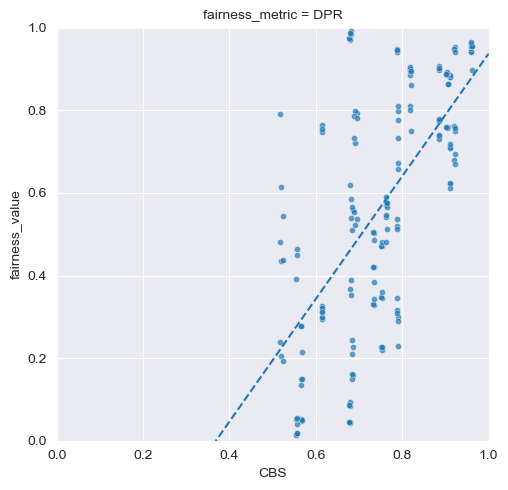

In [18]:
data = grouped_analysis_melted_fairness[True
        & (grouped_analysis_melted_fairness["mitigation"] == "none")
        & ~(grouped_analysis_melted_fairness["attribute"] == "attribute_3")
        & ~(grouped_analysis_melted_fairness["mitigated_attribute"] == "all")
        ].copy()

data = data.replace(["dpr", "dpdiff", "eoddsr", "eoddsdiff", "miss_rate_ratio", "fall_out_ratio"], ["DPR", "DPD", "EOR", "EOD", "MRR", "FOR"])


plot_scatter(data = data,
             col_x = "CBS",
             col_y="fairness_metric",
             col_y_values="fairness_value",
             col_order=[
                 "DPR",
                #  "DPD",
                #  "EOR",
                #  "EOD",
                #  "MRR",
                # "FOR",
                # "CFS_pred"
                 ],
             datasets=datasets,
             mitigations=balancing_strategies,
            annotate=True,
            #  hue = "dataset",
            # save_as="CBS_plot_FOR.pdf"
             )

PLOT CBS AND CBS_REG WITH MODEL FAIRNESS (MITIG)

Table 9 line 1

c:\Users\lequeup\OneDrive - FUJITSU\Documents\PHASE\Code\.conda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


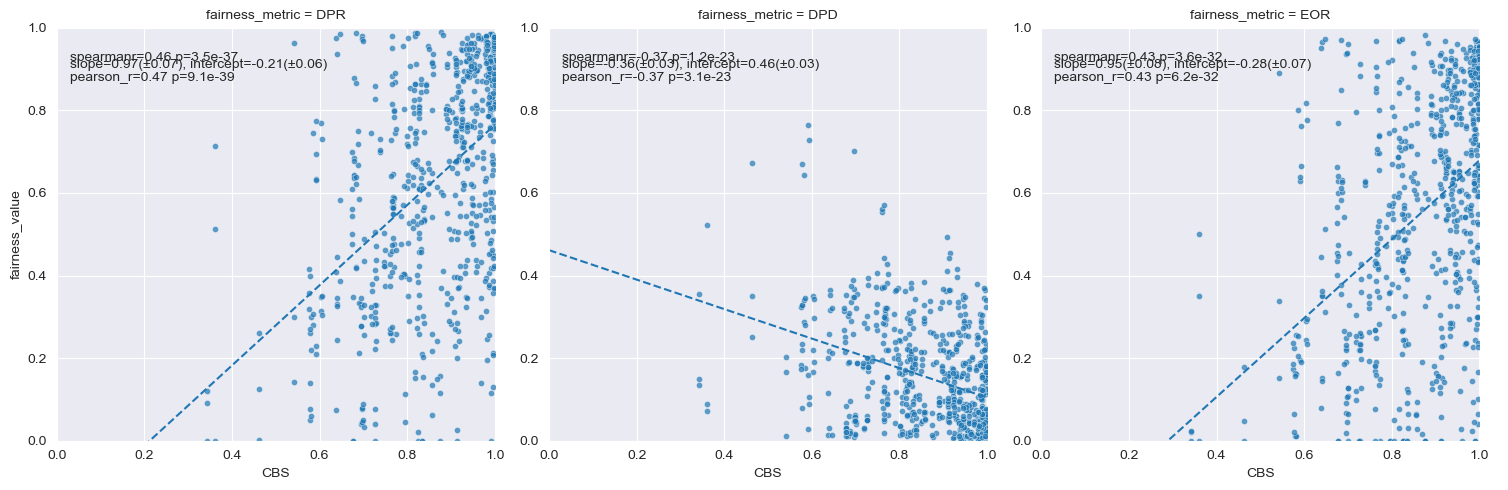

In [73]:
data = grouped_analysis_melted_fairness[True
        & ~(grouped_analysis_melted_fairness["mitigation"] == "none")
        & ~(grouped_analysis_melted_fairness["attribute"] == "attribute_3")
        & ~(grouped_analysis_melted_fairness["mitigated_attribute"] == "all")
        ].copy()

data = data.replace(["dpr", "dpdiff", "eoddsr", "eoddsdiff", "miss_rate_ratio", "fall_out_ratio"], ["DPR", "DPD", "EOR", "EOD", "MRR", "FOR"])

plot_scatter(data =  data,
             col_x = "CBS",
             col_y="fairness_metric",
             col_y_values="fairness_value",
             col_order=[
                 "DPR",
                 "DPD",
                 "EOR",
                #  "EOD",
                #  "MRR",
                # "FOR",
                # "CBS_pred"
                 ],
             datasets=datasets,
             mitigations=balancing_strategies,
             annotate=True
            #  hue = "mitigation",
            # save_as="CBS_reg_plot_MRR.pdf"
             )

Table 9 line 2

In [54]:
grouped_analysis_melted_fairness[True
        & ~(grouped_analysis_melted_fairness["mitigation"] == "none")
        & ~(grouped_analysis_melted_fairness["attribute"] == "attribute_3")
        & ~(grouped_analysis_melted_fairness["mitigated_attribute"] == "all")
        ]["dataset"].unique()

array(['ACS_E', 'ACS_I', 'ACS_M', 'ACS_P', 'ACS_T', 'KDD_census', 'adult',
       'bank_marketing', 'compas', 'german'], dtype=object)

c:\Users\lequeup\OneDrive - FUJITSU\Documents\PHASE\Code\.conda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


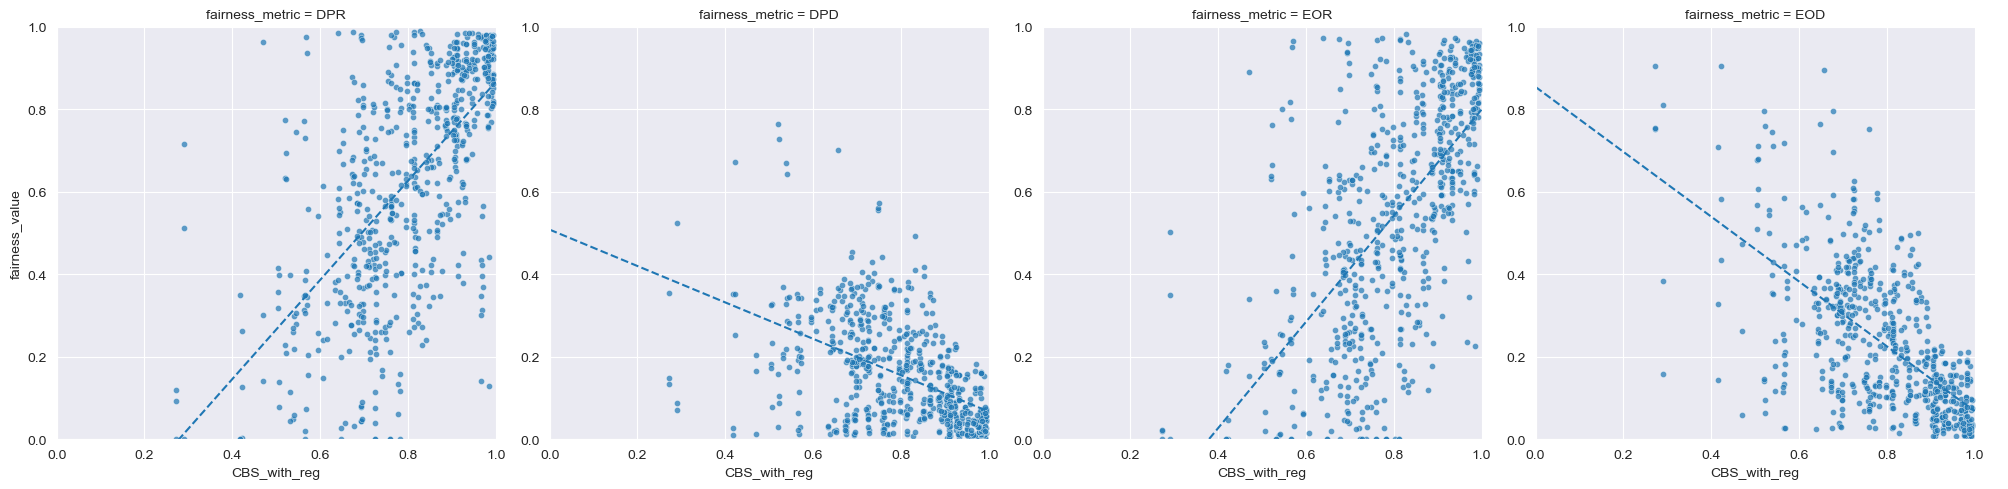

In [20]:
data = grouped_analysis_melted_fairness[True
        & ~(grouped_analysis_melted_fairness["mitigation"] == "none")
        & ~(grouped_analysis_melted_fairness["attribute"] == "attribute_3")
        & ~(grouped_analysis_melted_fairness["mitigated_attribute"] == "all")
        ].copy()

data = data.replace(["dpr", "dpdiff", "eoddsr", "eoddsdiff", "miss_rate_ratio", "fall_out_ratio"], ["DPR", "DPD", "EOR", "EOD", "MRR", "FOR"])

plot_scatter(data =  data,
             col_x = "CBS_with_reg",
             col_y="fairness_metric",
             col_y_values="fairness_value",
             col_order=[
                 "DPR",
                 "DPD",
                 "EOR",
                 "EOD",
                #  "MRR",
                # "FOR",
                # "CBS_pred"
                 ],
             datasets=datasets,
             mitigations=balancing_strategies,
             annotate=False,
            #  hue = "mitigation",
        #     save_as="CBS_reg_plot_FOR.pdf"
             )

Table 11

c:\Users\lequeup\OneDrive - FUJITSU\Documents\PHASE\Code\.conda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


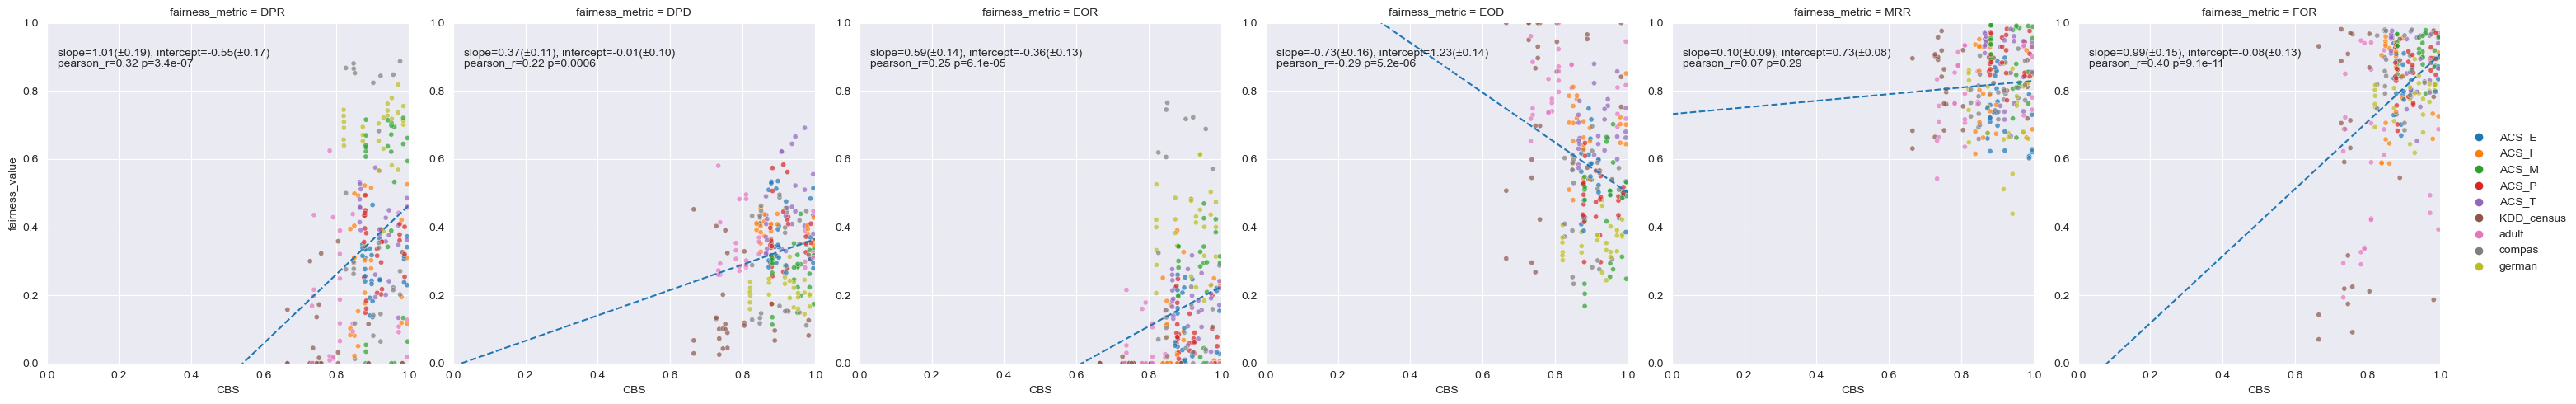

In [83]:
data = grouped_analysis_melted_fairness[True
        & ~(grouped_analysis_melted_fairness["mitigation"] == "none")
        & (grouped_analysis_melted_fairness["attribute"] == "attribute_3")
        & (grouped_analysis_melted_fairness["mitigated_attribute"] == "all")
        ].copy()

data = data.replace(["dpr", "dpdiff", "eoddsr", "eoddsdiff", "miss_rate_ratio", "fall_out_ratio"], ["DPR", "DPD", "EOR", "EOD", "MRR", "FOR"])

plot_scatter(data =  data,
             col_x = "CBS",
             col_y="fairness_metric",
             col_y_values="fairness_value",
             col_order=[
                 "DPR",
                 "DPD",
                 "EOR",
                 "EOD",
                 "MRR",
                 "FOR",
                # "CBS_pred"
                 ],
             datasets=datasets,
             mitigations=balancing_strategies,
             annotate=False,
             hue = "dataset",
            # save_as="CBS_reg_plot_FOR.pdf"
             )

# CBS Threshold

In [25]:
data = grouped_analysis_df[(grouped_analysis_df["attribute"] != "attribute_3")
                            & (grouped_analysis_df["mitigation"] == "none")
                            ].copy()


thresholds = [0.55 + 0.05*i for i in range(8)]
# thresholds = [0.80]
metrics = ["acc","ap","auc","f1","prec","rec", "dpr","dpdiff","eoddsr","eoddsdiff","fall_out_ratio", "miss_rate_ratio"]
improvements = []
for threshold in thresholds :
    df = data.copy()
    df["biased"] = df["CBS"] < threshold
    df = df[["biased"] + metrics].groupby(["biased"]).mean().round(2).reset_index()

    mean_improvement = 0
    for metric in ["dpr","dpdiff","eoddsr","eoddsdiff","fall_out_ratio", "miss_rate_ratio"] :
        improvement =  (df.loc[0,metric] - df.loc[1,metric])/df.loc[0,metric]
        df.loc[2, metric] =  improvement
        # print(metric, improvement)
        mean_improvement += np.abs(improvement)
    mean_improvement = (mean_improvement / 6)*100
    improvements.append(mean_improvement)

results = pd.DataFrame({"CBS threshold": thresholds, "Average fairness metrics difference (%)": improvements})
results

results

,CBS threshold,Average fairness metrics difference (%)
0,0.55,36.809221
1,0.60,59.197878
2,0.65,44.954172
3,0.70,36.632146
4,0.75,40.012980
5,0.80,89.553113
6,0.85,83.118095
7,0.90,77.242197


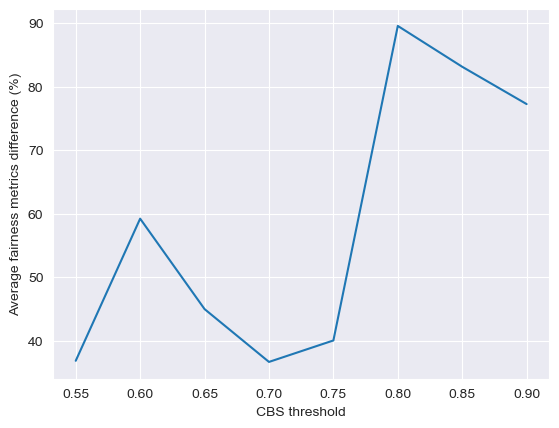

In [27]:
sns.lineplot(results, x="CBS threshold", y="Average fairness metrics difference (%)")
plt.savefig("./figures/CBS_threshold.pdf")

In [58]:
metrics = ["acc","ap","auc","f1","prec","rec", "dpr","dpdiff","eoddsr","eoddsdiff","fall_out_ratio", "miss_rate_ratio"]
data = grouped_analysis_df[(grouped_analysis_df["attribute"] != "attribute_3")
                            & (grouped_analysis_df["mitigation"] == "none")
                            ].copy()
data["biased"] = data["CBS"] < 0.8
df = data[data["dataset"].isin(datasets)]

df = df[["biased"] + metrics].groupby(["biased"]).mean().round(2).reset_index()
for metric in metrics :
    df.loc[2, metric] =  (df.loc[0,metric] - df.loc[1,metric])/df.loc[0,metric]
df

,biased,acc,ap,auc,f1,prec,rec,dpr,dpdiff,eoddsr,eoddsdiff,fall_out_ratio,miss_rate_ratio
0,False,0.710000,0.75,0.780000,0.670000,0.710000,0.700000,0.83000,0.080,0.740000,0.10,0.740000,0.760000
1,True,0.730000,0.63,0.790000,0.590000,0.630000,0.660000,0.44000,0.230,0.340000,0.33,0.640000,0.720000
2,NaN,-0.028169,0.16,-0.012821,0.119403,0.112676,0.057143,0.46988,-1.875,0.540541,-2.30,0.135135,0.052632


# Tabular analysis

In [16]:
def tabular_results(data=grouped_analysis_df, datasets=datasets, group=["mitigation"], plot = True, group_order = None, saveas = None) :
    metrics = ["acc","ap","auc","f1","prec","rec", "dpr","dpdiff","eoddsr","eoddsdiff","fall_out_ratio", "miss_rate_ratio"]
    df = data[data["dataset"].isin(datasets)].copy()
    df = df[group + metrics].groupby(group).mean().round(2).reset_index()

    high_to_low_cols = ['acc', 'ap', 'auc', 'f1', 'prec', 'rec', 'dpr', 'eoddsr', "fall_out_ratio", "miss_rate_ratio"]
    low_to_high_cols = [col for col in df.columns if col not in group + high_to_low_cols]

    styled_df = df.style.highlight_max(color='green', axis=0,subset=high_to_low_cols)
    styled_df = styled_df.highlight_min(color='red', axis=0,subset=high_to_low_cols)
    styled_df = styled_df.highlight_min(color='green', axis=0,subset=low_to_high_cols)
    styled_df = styled_df.highlight_max(color='red', axis=0,subset=low_to_high_cols)

    if plot :
        df_test_melted = df.melt(id_vars = group, value_vars =  metrics, var_name="metric", value_name="value")
        if not group_order :
            group_order = df[group[0]].unique()
        g = sns.FacetGrid(df_test_melted,
                      col = "metric",
                      col_order = ["acc", "ap", "auc", "f1", "prec", "rec"],
                      height=5,
                      sharey= False,
                      hue=  group[0]
                      )
        sns.set_style("darkgrid")
        g.map_dataframe(sns.barplot, x=group[0], y="value", order = group_order)
        g.add_legend()
        plt.gca().set_xticklabels([])
        h = sns.FacetGrid(df_test_melted,
                      col = "metric",
                      col_order = ["dpdiff", "dpr", "eoddsdiff","eoddsr", "miss_rate_ratio", "fall_out_ratio"],
                      height=5,
                      sharey= False,
                      hue=  group[0]
                      )
        sns.set_style("darkgrid")

        h.map_dataframe(sns.barplot, x=group[0], y="value", order = group_order)
        h.add_legend()
        plt.gca().set_xticklabels([])

    if saveas:
        df.to_csv(saveas, index=False)

    return styled_df

INDIVIDUAL FAIRNESS

Table 7

In [59]:
tabular_results(data=grouped_unnormalized_df[ True
                                            & ((grouped_unnormalized_df["mitigated_attribute"] == grouped_unnormalized_df["attribute"])
                                            | (grouped_unnormalized_df["mitigated_attribute"] == "none"))
                                            & ~(grouped_unnormalized_df["attribute"].isin(["attribute_3"]))
                                            & ~(grouped_unnormalized_df["mitigated_attribute"].isin(["all"]))
                                            & (grouped_unnormalized_df["dataset"].isin(datasets))
                                            ],
                datasets=datasets,
                group=["mitigation"],
                plot = False,
                # saveas = "./analysis/individual_fairness_mitigation_results.csv"
                )

,mitigation,acc,ap,auc,f1,prec,rec,dpr,dpdiff,eoddsr,eoddsdiff,fall_out_ratio,miss_rate_ratio
0,balance_all,0.710000,0.640000,0.770000,0.600000,0.620000,0.660000,0.680000,0.120000,0.590000,0.200000,0.800000,0.800000
1,balance_output,0.700000,0.650000,0.780000,0.610000,0.590000,0.740000,0.570000,0.220000,0.490000,0.270000,0.690000,0.690000
2,balance_output_for_attribute,0.720000,0.660000,0.780000,0.620000,0.630000,0.690000,0.700000,0.120000,0.620000,0.190000,0.820000,0.810000
3,balance_protected_attribute,0.710000,0.650000,0.770000,0.590000,0.640000,0.650000,0.580000,0.160000,0.490000,0.240000,0.690000,0.760000
4,none,0.730000,0.670000,0.790000,0.610000,0.650000,0.670000,0.560000,0.190000,0.470000,0.260000,0.670000,0.740000


In [ ]:
2/73 + 2 / 67 +

Table 8

In [18]:
tabular_results(data=grouped_unnormalized_df[ True
                                            & ((grouped_unnormalized_df["mitigated_attribute"] == grouped_unnormalized_df["attribute"])
                                               | (grouped_unnormalized_df["mitigated_attribute"] == "none"))
                                            & ~(grouped_unnormalized_df["attribute"].isin(["attribute_3"]))
                                            & ~(grouped_unnormalized_df["mitigated_attribute"].isin(["all"]))
                                          #   & ~(grouped_unnormalized_df["mitigation"].isin(["complete_balance"]))
                                            ],
                datasets=datasets,
                group=["sampling"],
                plot = False,
                # saveas = "./analysis/individual_fairness_sampling_results.csv"
                )

,sampling,acc,ap,auc,f1,prec,rec,dpr,dpdiff,eoddsr,eoddsdiff,fall_out_ratio,miss_rate_ratio
0,RandomOverSampler,0.720000,0.660000,0.780000,0.610000,0.630000,0.690000,0.620000,0.160000,0.530000,0.230000,0.740000,0.760000
1,RandomUnderSampler,0.710000,0.650000,0.770000,0.600000,0.620000,0.670000,0.620000,0.160000,0.540000,0.230000,0.740000,0.770000
2,SMOTENC,0.720000,0.660000,0.780000,0.610000,0.630000,0.690000,0.610000,0.160000,0.520000,0.240000,0.720000,0.760000


Table 10 First line

In [20]:
styler = tabular_results(data=grouped_unnormalized_df[True
                                                    &((grouped_unnormalized_df["mitigated_attribute"] == grouped_unnormalized_df["attribute"])
                                                     | (grouped_unnormalized_df["mitigated_attribute"] == "none"))
                                                    & ~(grouped_unnormalized_df["dataset"].isin(["bank_marketing"])) # because it has only one attribute
                                                    & ~(grouped_unnormalized_df["attribute"].isin(["attribute_3"]))
                                                    & ~(grouped_unnormalized_df["mitigated_attribute"].isin(["all"]))
                                                    & (grouped_unnormalized_df["mitigation"].isin(["none", "balance_output_for_attribute"]))
                                                    ],
                datasets=datasets,
                group=["mitigation", "attribute"],
                plot = False,
                # saveas = "./analysis/individual_fairness_sampling_results.csv"
                )

metrics = ["acc","ap","auc","f1","prec","rec", "dpr","dpdiff","eoddsr","eoddsdiff","fall_out_ratio", "miss_rate_ratio"]
df = styler.data
for metric in metrics :
    df.loc[4, metric] =  (df.loc[0,metric] - df.loc[2,metric])/df.loc[2,metric]
    df.loc[5, metric] =  (df.loc[1,metric] - df.loc[3,metric])/df.loc[3,metric]
df.loc[4:5][metrics].mean()

acc               -0.013889
ap                -0.007353
auc                0.000000
f1                 0.000000
prec              -0.022727
rec                0.014493
dpr                0.221243
dpdiff            -0.337662
eoddsr             0.327260
eoddsdiff         -0.233766
fall_out_ratio     0.210504
miss_rate_ratio    0.093874
dtype: float64

INDIVIDUAL FAIRNESS ON OTHER ATTRIBUTE

In [22]:
grouped_unnormalized_df[True
                                            & ((grouped_unnormalized_df["mitigated_attribute"] != grouped_unnormalized_df["attribute"])
                                               | (grouped_unnormalized_df["mitigated_attribute"] == "none"))
                                            & ~(grouped_unnormalized_df["dataset"].isin(["bank_marketing"])) # because it has only one attribute
                                            & ~(grouped_unnormalized_df["attribute"].isin(["attribute_3"]))
                                            & ~(grouped_unnormalized_df["mitigated_attribute"].isin(["all"]))
                                            & (grouped_unnormalized_df["mitigation"].isin(["none", "balance_output_for_attribute"]))
                                            & (grouped_unnormalized_df["attribute"].isin(["attribute_1"]))
                                            ]

,model,dataset,sampling,mitigation,mitigated_attribute,attribute,CBS,balance_index,RMSDIR,RMSPMI,...,prec,rec,f1,dpdiff,dpr,eoddsdiff,eoddsr,miss_rate_ratio,fall_out_ratio,CBS_pred
18,Gaussian,ACS_E,RandomOverSampler,balance_output_for_attribute,attribute_2,attribute_1,0.907032,0.900116,0.860304,0.039324,...,0.450418,0.982797,0.617685,0.160447,0.758720,0.185429,0.653748,0.689463,0.653748,0.842342
30,Gaussian,ACS_E,RandomOverSampler,none,none,attribute_1,0.905268,0.886633,0.861486,0.032314,...,0.450480,0.984960,0.618175,0.160203,0.758596,0.185069,0.653414,0.724791,0.653414,0.843488
51,Gaussian,ACS_E,RandomUnderSampler,balance_output_for_attribute,attribute_2,attribute_1,0.935970,0.918203,0.913329,0.023621,...,0.456446,0.983850,0.623562,0.161235,0.758321,0.190749,0.645177,0.780323,0.645177,0.841986
63,Gaussian,ACS_E,RandomUnderSampler,none,none,attribute_1,0.903691,0.886525,0.857796,0.033247,...,0.449640,0.983322,0.617060,0.161425,0.757041,0.189717,0.646848,0.798912,0.646848,0.842811
84,Gaussian,ACS_E,SMOTENC,balance_output_for_attribute,attribute_2,attribute_1,0.905478,0.899761,0.857027,0.040355,...,0.450112,0.973181,0.615499,0.161523,0.754858,0.189916,0.643507,0.849962,0.643507,0.841513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676,RF,german,RandomOverSampler,none,none,attribute_1,0.818390,0.621000,0.891596,0.057426,...,0.778615,0.912324,0.839271,0.089886,0.895084,0.157392,0.779511,0.500430,0.793596,0.810282
2697,RF,german,RandomUnderSampler,balance_output_for_attribute,attribute_2,attribute_1,0.850906,0.669423,0.917147,0.033852,...,0.827694,0.805525,0.815702,0.051669,0.927505,0.113657,0.775681,0.678429,0.775681,0.837941
2709,RF,german,RandomUnderSampler,none,none,attribute_1,0.817427,0.617500,0.891983,0.057201,...,0.788001,0.911593,0.844609,0.079855,0.904622,0.136588,0.779841,0.697486,0.779841,0.821825
2730,RF,german,SMOTENC,balance_output_for_attribute,attribute_2,attribute_1,0.827589,0.551988,0.950087,0.019308,...,0.830513,0.839295,0.834361,0.082169,0.890994,0.137602,0.729389,0.738391,0.736274,0.816185


Table 10 Second line

In [24]:
styler = tabular_results(data=grouped_unnormalized_df[True
                                            & ((grouped_unnormalized_df["mitigated_attribute"] != grouped_unnormalized_df["attribute"])
                                               | (grouped_unnormalized_df["mitigated_attribute"] == "none"))
                                            & ~(grouped_unnormalized_df["dataset"].isin(["bank_marketing"])) # because it has only one attribute
                                            & ~(grouped_unnormalized_df["attribute"].isin(["attribute_3"]))
                                            & ~(grouped_unnormalized_df["mitigated_attribute"].isin(["all"]))
                                            & (grouped_unnormalized_df["mitigation"].isin(["none", "balance_output_for_attribute"]))
                                            # & (grouped_unnormalized_df["attribute"].isin(["attribute_2"]))
                                            ],
                datasets=datasets,
                group=["mitigation", 'attribute'],
                plot = False,
                # saveas = "./analysis/individual_fairness_sampling_results.csv"
                )

metrics = ["acc","ap","auc","f1","prec","rec", "dpr","dpdiff","eoddsr","eoddsdiff","fall_out_ratio", "miss_rate_ratio"]
df = styler.data

df
for metric in metrics :
    df.loc[4, metric] =  (df.loc[0,metric] - df.loc[2,metric])/df.loc[2,metric]
    df.loc[5, metric] =  (df.loc[1,metric] - df.loc[3,metric])/df.loc[3,metric]
df.loc[4:5][metrics].mean()

acc               -0.013889
ap                -0.007353
auc                0.000000
f1                 0.000000
prec              -0.022727
rec                0.014493
dpr                0.000000
dpdiff             0.022727
eoddsr             0.012821
eoddsdiff          0.040584
fall_out_ratio     0.021639
miss_rate_ratio    0.000090
dtype: float64

EFFECT OF INTERSECTIONAL BALANCE ON INDIVIDUAL ATTRIBUTES

Table 10 fourth line

In [26]:
styler = tabular_results(data=grouped_unnormalized_df[True
                                              & ~(grouped_unnormalized_df["dataset"].isin(["bank_marketing"])) # because it has only one attribute
                                              & ~(grouped_unnormalized_df["attribute"].isin(["attribute_3"]))
                                              & (grouped_unnormalized_df["mitigated_attribute"].isin(["all", "none"]))
                                              & (grouped_unnormalized_df["mitigation"].isin(["none", "balance_output_for_attribute"]))
                                              ],
                datasets=datasets,
                group=["mitigation", "attribute"],
                plot = False,
                # saveas = "./analysis/individual_fairness_sampling_results.csv"
                )

metrics = ["acc","ap","auc","f1","prec","rec", "dpr","dpdiff","eoddsr","eoddsdiff","fall_out_ratio", "miss_rate_ratio"]
df = styler.data


for metric in metrics :
    df.loc[4, metric] =  (df.loc[0,metric] - df.loc[2,metric])/df.loc[2,metric]
    df.loc[5, metric] =  (df.loc[1,metric] - df.loc[3,metric])/df.loc[3,metric]
df.loc[4:5][metrics].mean()


acc               -0.013889
ap                -0.014706
auc                0.000000
f1                 0.000000
prec              -0.030303
rec                0.014493
dpr                0.211039
dpdiff            -0.279221
eoddsr             0.301619
eoddsdiff         -0.233766
fall_out_ratio     0.188866
miss_rate_ratio    0.093874
dtype: float64

INTERSECTIONAL FAIRNESS

Table 10 third line

In [32]:
styler = tabular_results(data=grouped_unnormalized_df[True
                                              & ~(grouped_unnormalized_df["dataset"].isin(["bank_marketing"])) # because it has only one attribute
                                              & (grouped_unnormalized_df["attribute"].isin(["attribute_3"]))
                                              & (grouped_unnormalized_df["mitigated_attribute"].isin(["all", "none"]))
                                              & (grouped_unnormalized_df["mitigation"].isin(["none", "balance_output_for_attribute"]))
                                              ],
                datasets=datasets,
                group=["mitigation", "attribute"],
                plot = False,
                # saveas = "./analysis/individual_fairness_sampling_results.csv"
                )

metrics = ["acc","ap","auc","f1","prec","rec", "dpr","dpdiff","eoddsr","eoddsdiff","fall_out_ratio", "miss_rate_ratio"]
df = styler.data
for metric in metrics :
    df.loc[2, metric] =  (df.loc[0,metric] - df.loc[1,metric])/df.loc[1,metric]
df

,mitigation,attribute,acc,ap,auc,f1,prec,rec,dpr,dpdiff,eoddsr,eoddsdiff,fall_out_ratio,miss_rate_ratio
0,balance_output_for_attribute,attribute_3,0.710000,0.670000,0.78,0.63,0.640000,0.700000,0.390000,0.310000,0.170000,0.580000,0.840000,0.830000
1,none,attribute_3,0.720000,0.680000,0.78,0.63,0.660000,0.690000,0.280000,0.380000,0.120000,0.630000,0.730000,0.770000
2,NaN,NaN,-0.013889,-0.014706,0.00,0.00,-0.030303,0.014493,0.392857,-0.184211,0.416667,-0.079365,0.150685,0.077922


# Fairness / Utility Variation Plot
not used in the article but gives valuable insight on the fairness-utility tradeoff

c:\Users\lequeup\OneDrive - FUJITSU\Documents\PHASE\Code\.conda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\lequeup\OneDrive - FUJITSU\Documents\PHASE\Code\.conda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\lequeup\OneDrive - FUJITSU\Documents\PHASE\Code\.conda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\lequeup\OneDrive - FUJITSU\Documents\PHASE\Code\.conda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


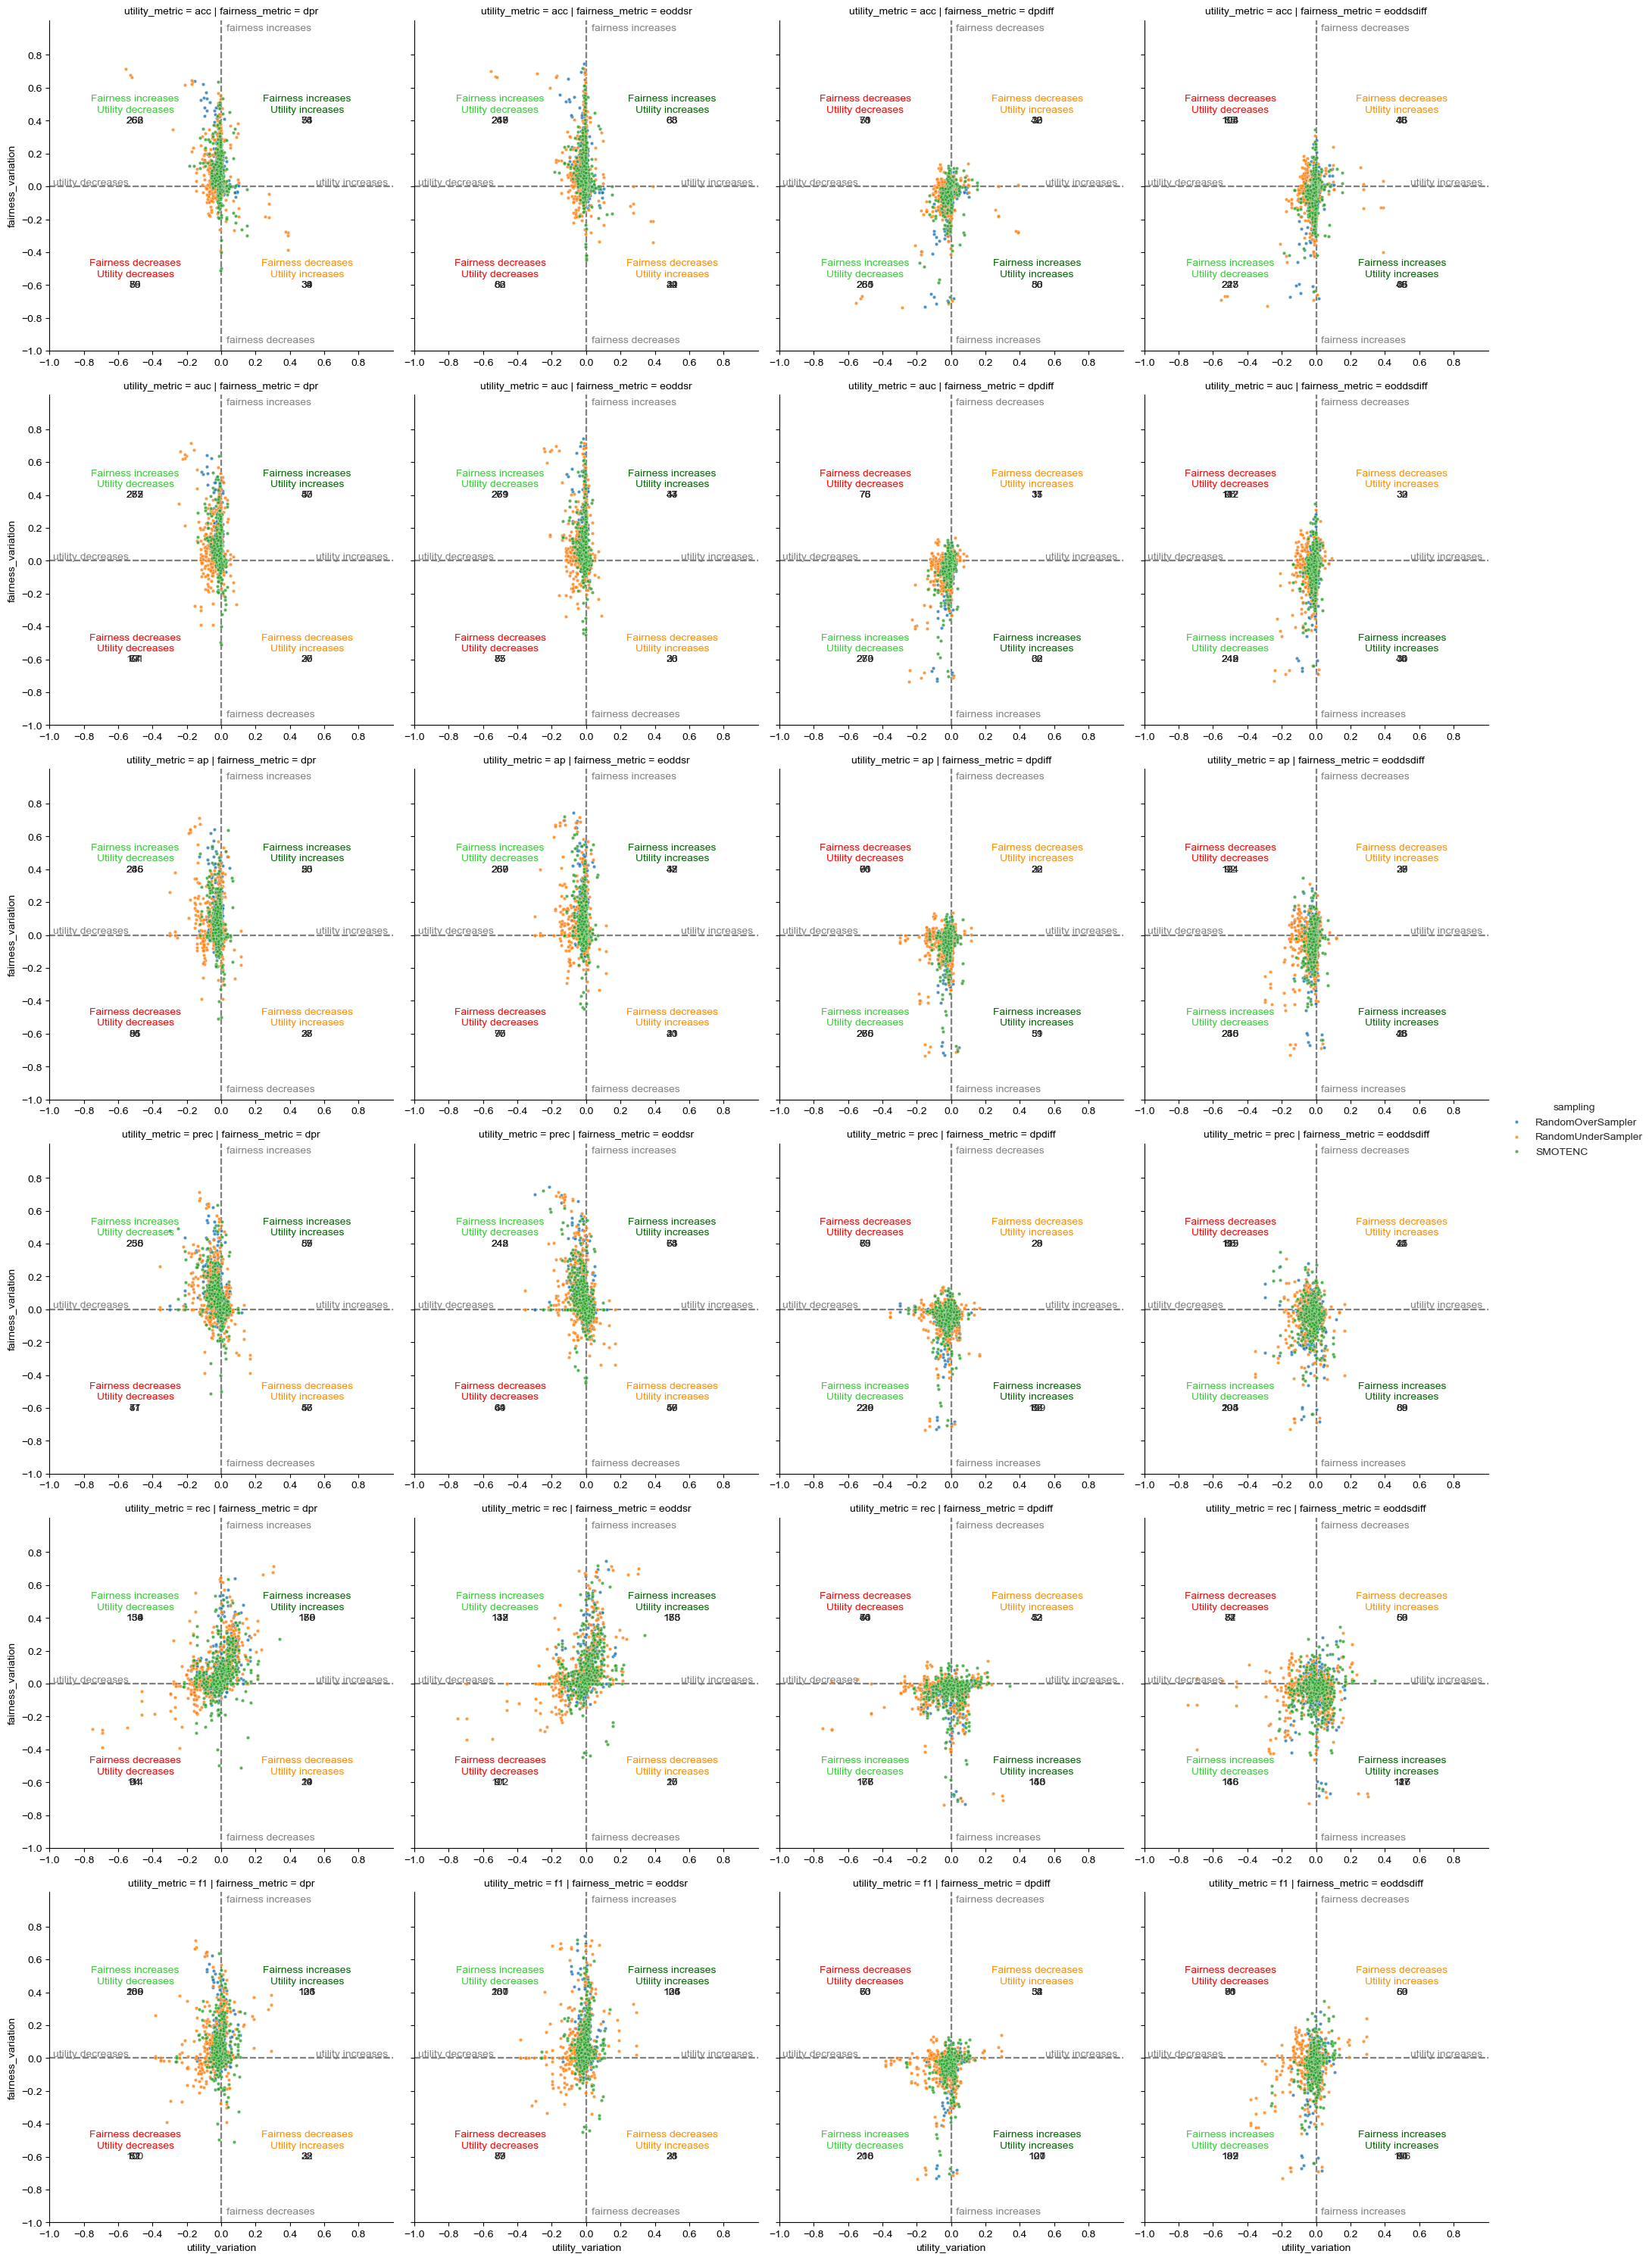

In [34]:
g = sns.FacetGrid(grouped_delta_analysis_df_melted[(grouped_delta_analysis_df_melted["dataset"].isin(datasets))
                                                   & ~(grouped_delta_analysis_df_melted["mitigation"].isin(["balance_output", "balance_attribute"]))
                                                #    & ~(grouped_delta_analysis_df_melted["sampling"].isin(["SMOTENC"]))
                                                #    & (grouped_delta_analysis_df_melted["model"] == "RF")
                                                   ],
                  row = "utility_metric",
                  col = "fairness_metric",
                  col_order=["dpr", "eoddsr", "dpdiff", "eoddsdiff"],
                  hue="sampling",
                  height=5,
                  sharex=False)

sns.set_style("darkgrid")
g.map(plt.axvline, x=0, color="gray", linestyle='--')
g.map(plt.axhline, y=0, color="gray", linestyle='--')
# g.map_dataframe(sns.kdeplot, x='utility_variation', y="fairness_variation", zorder=2, aplha=.5)
g.map_dataframe(sns.scatterplot, x='utility_variation', y="fairness_variation", zorder=2, s=10, alpha=.8)
limit_count = 0.00
def annotate(data, **kws):

    ax = plt.gca()
    # Fairness >0, Utility <0
    ax.text(-0.5, 0.4, data[(data["fairness_variation"] >= 0) & (data["utility_variation"] < -0) & (np.sqrt(data["fairness_variation"]**2 + data["utility_variation"]**2) > limit_count)].shape[0],va="center", ha="center")
    # Fairness <0, Utility <0
    ax.text(-0.5, -0.6, data[(data["fairness_variation"] < -0) & (data["utility_variation"] < -0) & (np.sqrt(data["fairness_variation"]**2 + data["utility_variation"]**2) > limit_count)].shape[0],va="center", ha="center")
    # Fairness >=0, Utility >=0
    ax.text(0.50, 0.4, data[(data["fairness_variation"] >= 0) & (data["utility_variation"] >= 0) & (np.sqrt(data["fairness_variation"]**2 + data["utility_variation"]**2) > limit_count)].shape[0],va="center", ha="center")
    # Fairness <0, Utility >=0
    ax.text(0.5, -0.6, data[(data["fairness_variation"] < -0) & (data["utility_variation"] >= 0) & (np.sqrt(data["fairness_variation"]**2 + data["utility_variation"]**2) > limit_count)].shape[0],va="center", ha="center")

    # ax.add_patch(plt.Circle((0,0), limit_count, color="r", fill=False, zorder=3))
g.map_dataframe(annotate)
axes=g.axes
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]) :
        ax = axes[row,col]
        if col <= 1:
            ax.text(0.03, 0.95, "fairness increases", fontsize=10, color='gray')
            ax.text(0.03, -0.95, "fairness decreases", fontsize=10, color='gray')
            ax.text(0.55, 0.01, "utility increases", fontsize=10, color='gray')
            ax.text(-0.98, 0.01, "utility decreases", fontsize=10, color='gray')

            ax.text(-0.50, 0.50, "Fairness increases\nUtility decreases", fontsize=10, color='limegreen',va="center", ha="center")
            ax.text(-0.50, -0.50, "Fairness decreases\nUtility decreases", fontsize=10, color='red',va="center", ha="center")
            ax.text( 0.50, 0.50, "Fairness increases\nUtility increases", fontsize=10, color='darkgreen',va="center", ha="center")
            ax.text( 0.50, -0.50, "Fairness decreases\nUtility increases", fontsize=10, color='darkorange',va="center", ha="center")
        else:
            ax.text(0.03, 0.95, "fairness decreases", fontsize=10, color='gray')
            ax.text(0.03, -0.95, "fairness increases", fontsize=10, color='gray')
            ax.text(0.55, 0.01, "utility increases", fontsize=10, color='gray')
            ax.text(-0.98, 0.01, "utility decreases", fontsize=10, color='gray')

            ax.text(-0.50, 0.50, "Fairness decreases\nUtility decreases", fontsize=10, color='red',va="center", ha="center")
            ax.text(-0.50, -0.50, "Fairness increases\nUtility decreases", fontsize=10, color='limegreen',va="center", ha="center")
            ax.text( 0.50, 0.50, "Fairness decreases\nUtility increases", fontsize=10, color='darkorange',va="center", ha="center")
            ax.text( 0.50, -0.50, "Fairness increases\nUtility increases", fontsize=10, color='darkgreen',va="center", ha="center")

g.add_legend()
g.set(xlim=(-1,1.001), ylim=(-1,1.01),xticks=np.arange(-1,1,0.2), yticks=np.arange(-1,1,0.2))

# Histograms 

In [36]:
def plot_histogram(data=analysis_melted_fairness,
                 col_x = "fairness_metric",
                 col_x_value = "fairness_value",
                 col_y="mitigation",
                 col_y_values = "fairness_value",
                 col_order = ["none", "balance_output", "balance_protected_attribute", "balance_output_for_attribute", "balance_all"],
                 datasets = datasets,
                 mitigations = balancing_strategies,
                 hue= None) :

    def specs(x, **kwargs):
        plt.axvline(x.mean(), c='k', ls='--', lw=1)
        mean  ="{:.2f}".format(x.mean())
        # median  ="{:.2f}".format(x.median())
        ax = plt.gca()
        plt.text(x = x.mean() + 0.05, y= 0.85, s = "mean\n" + mean, transform = ax.transAxes)
        # plt.axvline(x.median(), c='grey', ls='--', lw=2.5)
        # plt.text(x = x.median() + 0.05, y= 0.75, s = "median\n" + median, c = "grey",  transform = ax.transAxes, zorder=2)

    g = sns.FacetGrid(data[data["dataset"].isin(datasets)
                           & data["mitigation"].isin(mitigations)],
                      col=col_y,
                      col_order=col_order,
                      row = col_x,
                      height=5,
                      sharey=True,
                      sharex=False,
                      legend_out=True,
                      hue=hue)
    g.map_dataframe(sns.histplot, x= col_x_value, common_norm=True, bins=np.arange(0,1.05,0.1), alpha= .5, kde=True, stat="count")
    plt.tight_layout()
    g.map(specs,col_y_values)
    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    g.add_legend()


Plot the histogram of fairness per balancing strategies

c:\Users\lequeup\OneDrive - FUJITSU\Documents\PHASE\Code\.conda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\lequeup\AppData\Local\Temp\ipykernel_4748\971617561.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
c:\Users\lequeup\OneDrive - FUJITSU\Documents\PHASE\Code\.conda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


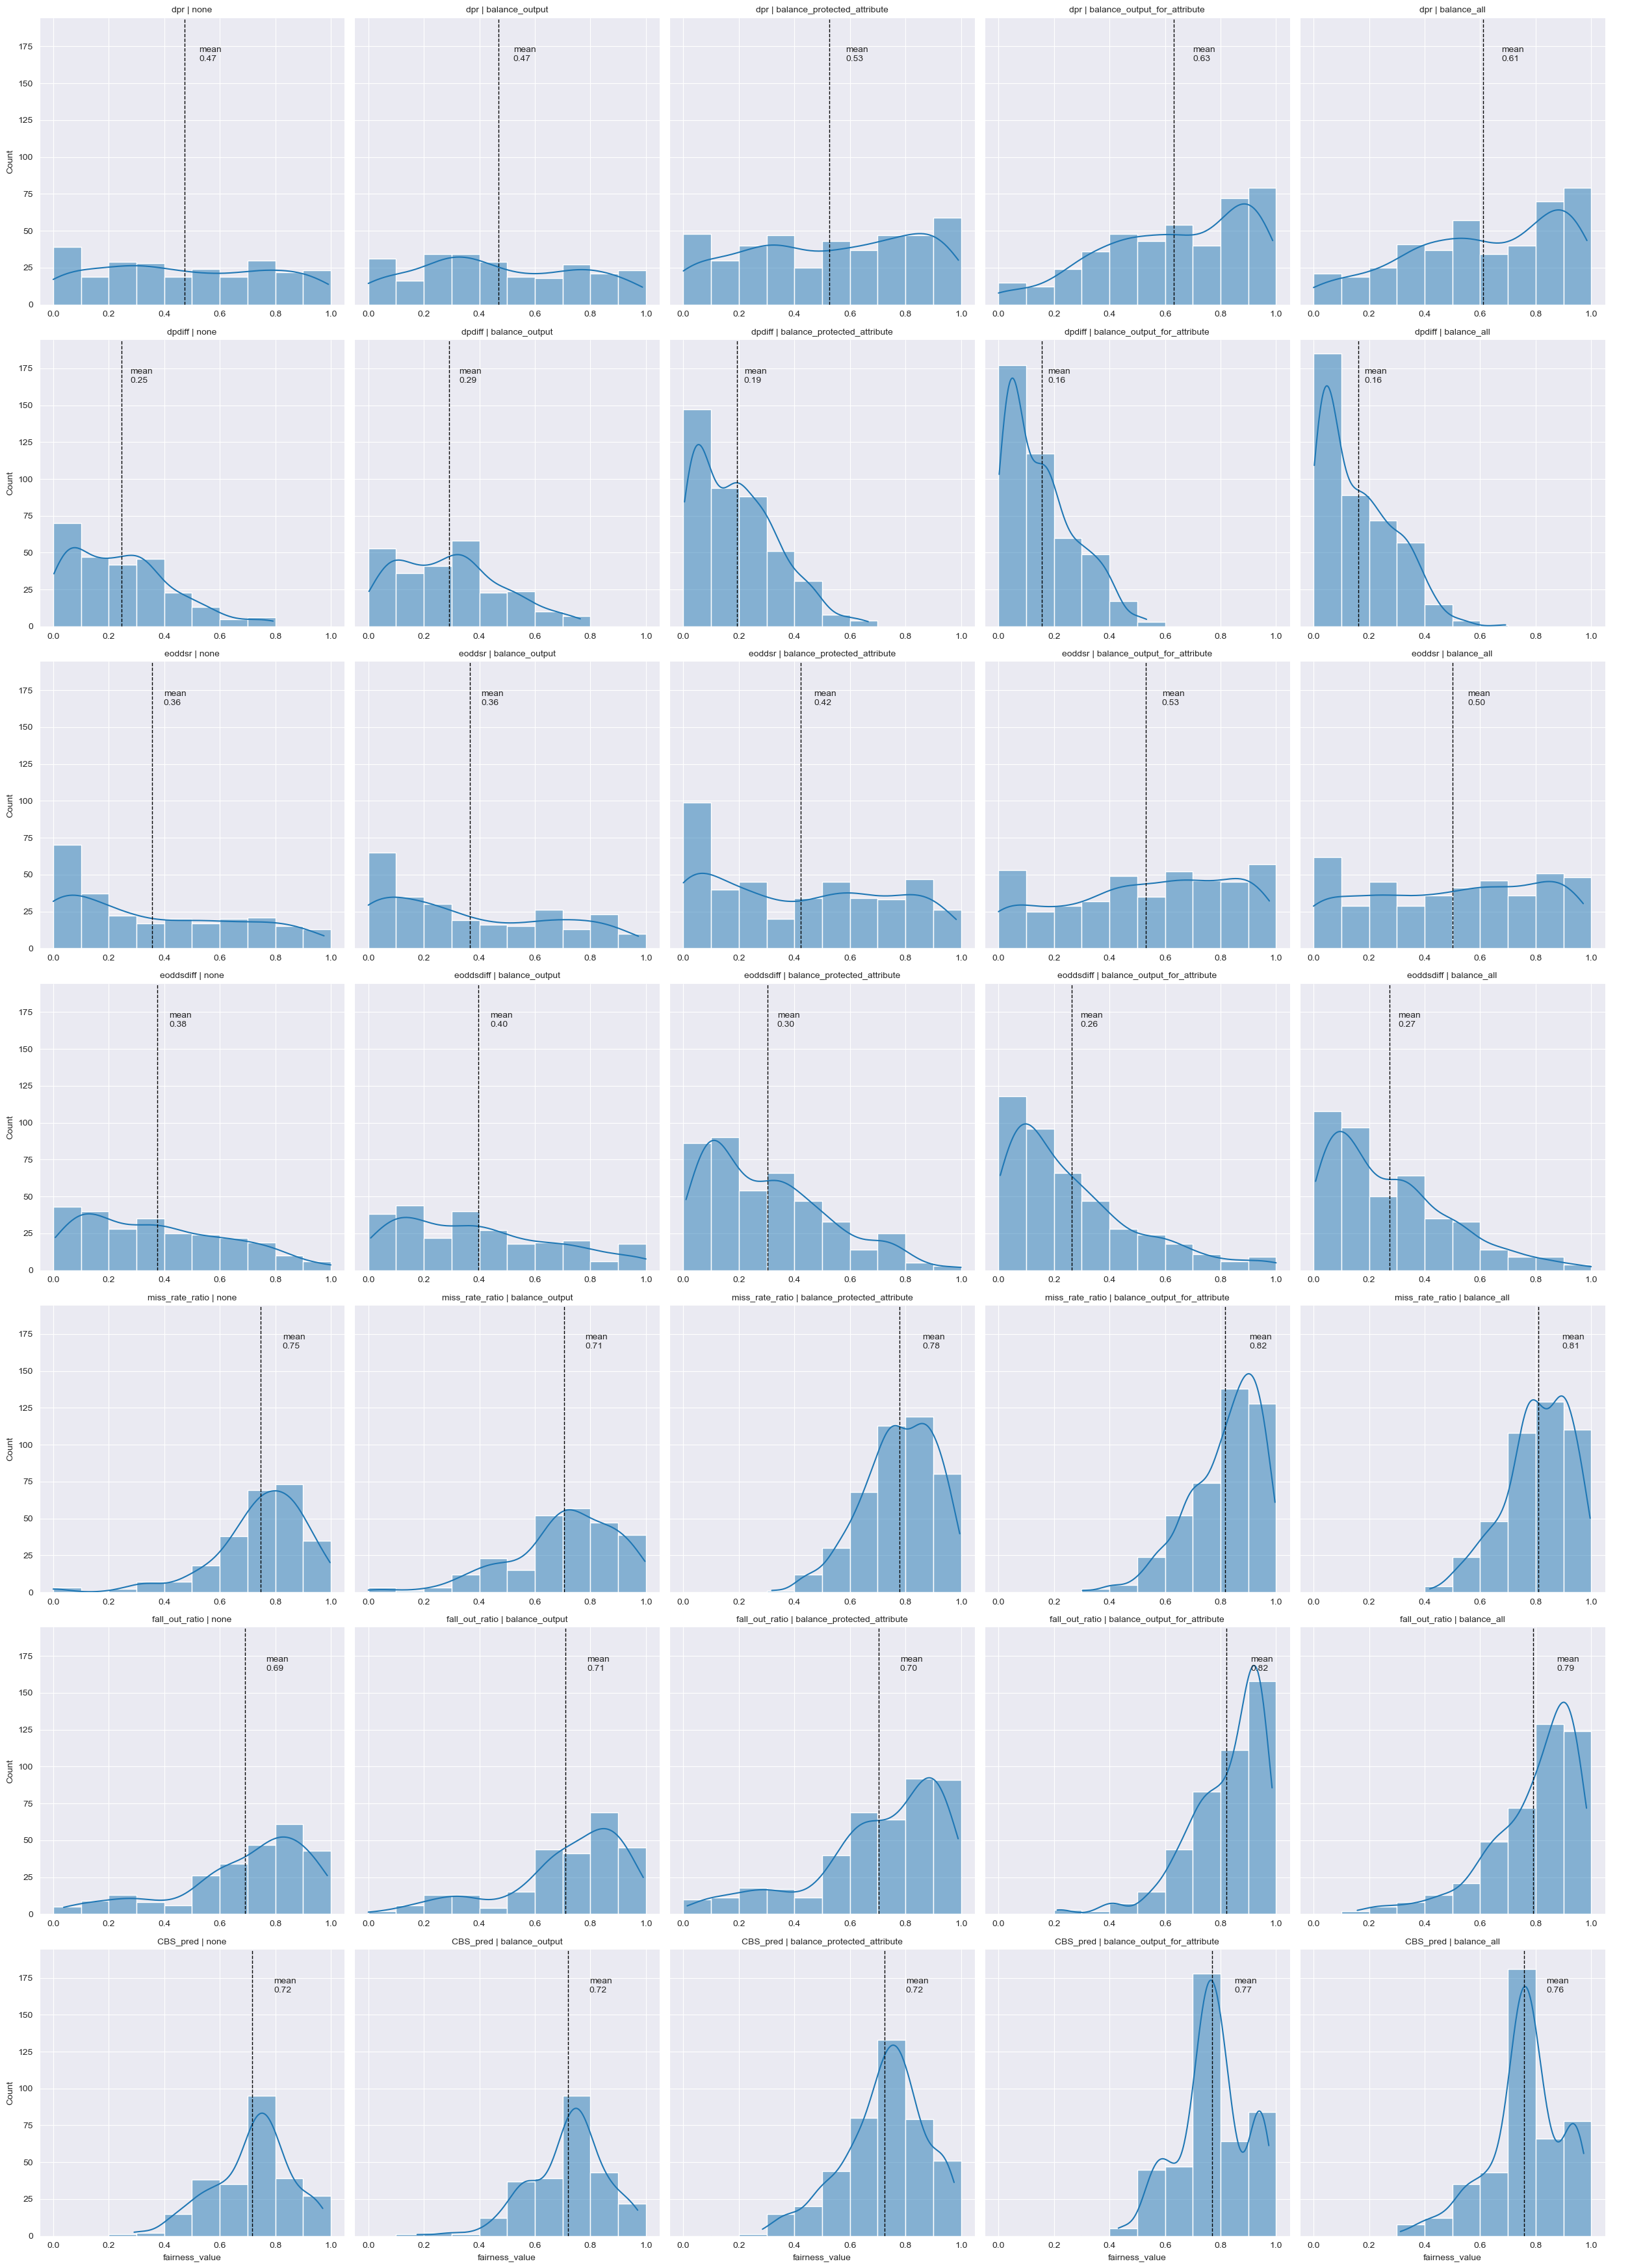

In [37]:
plot_histogram(data=grouped_analysis_melted_fairness,
                col_x = "fairness_metric",
                col_x_value = "fairness_value",
                col_y="mitigation",
                col_y_values = "fairness_value",
                col_order = ["none", "balance_output", "balance_protected_attribute", "balance_output_for_attribute", "balance_all"],
                datasets = datasets,
                mitigations = ["none", "balance_output",  "balance_protected_attribute", "balance_output_for_attribute", "balance_all"],
                # hue= "sampling"
                )

Plot the histogram of utility per balancing strategies

c:\Users\lequeup\OneDrive - FUJITSU\Documents\PHASE\Code\.conda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\lequeup\AppData\Local\Temp\ipykernel_4748\971617561.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
c:\Users\lequeup\OneDrive - FUJITSU\Documents\PHASE\Code\.conda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


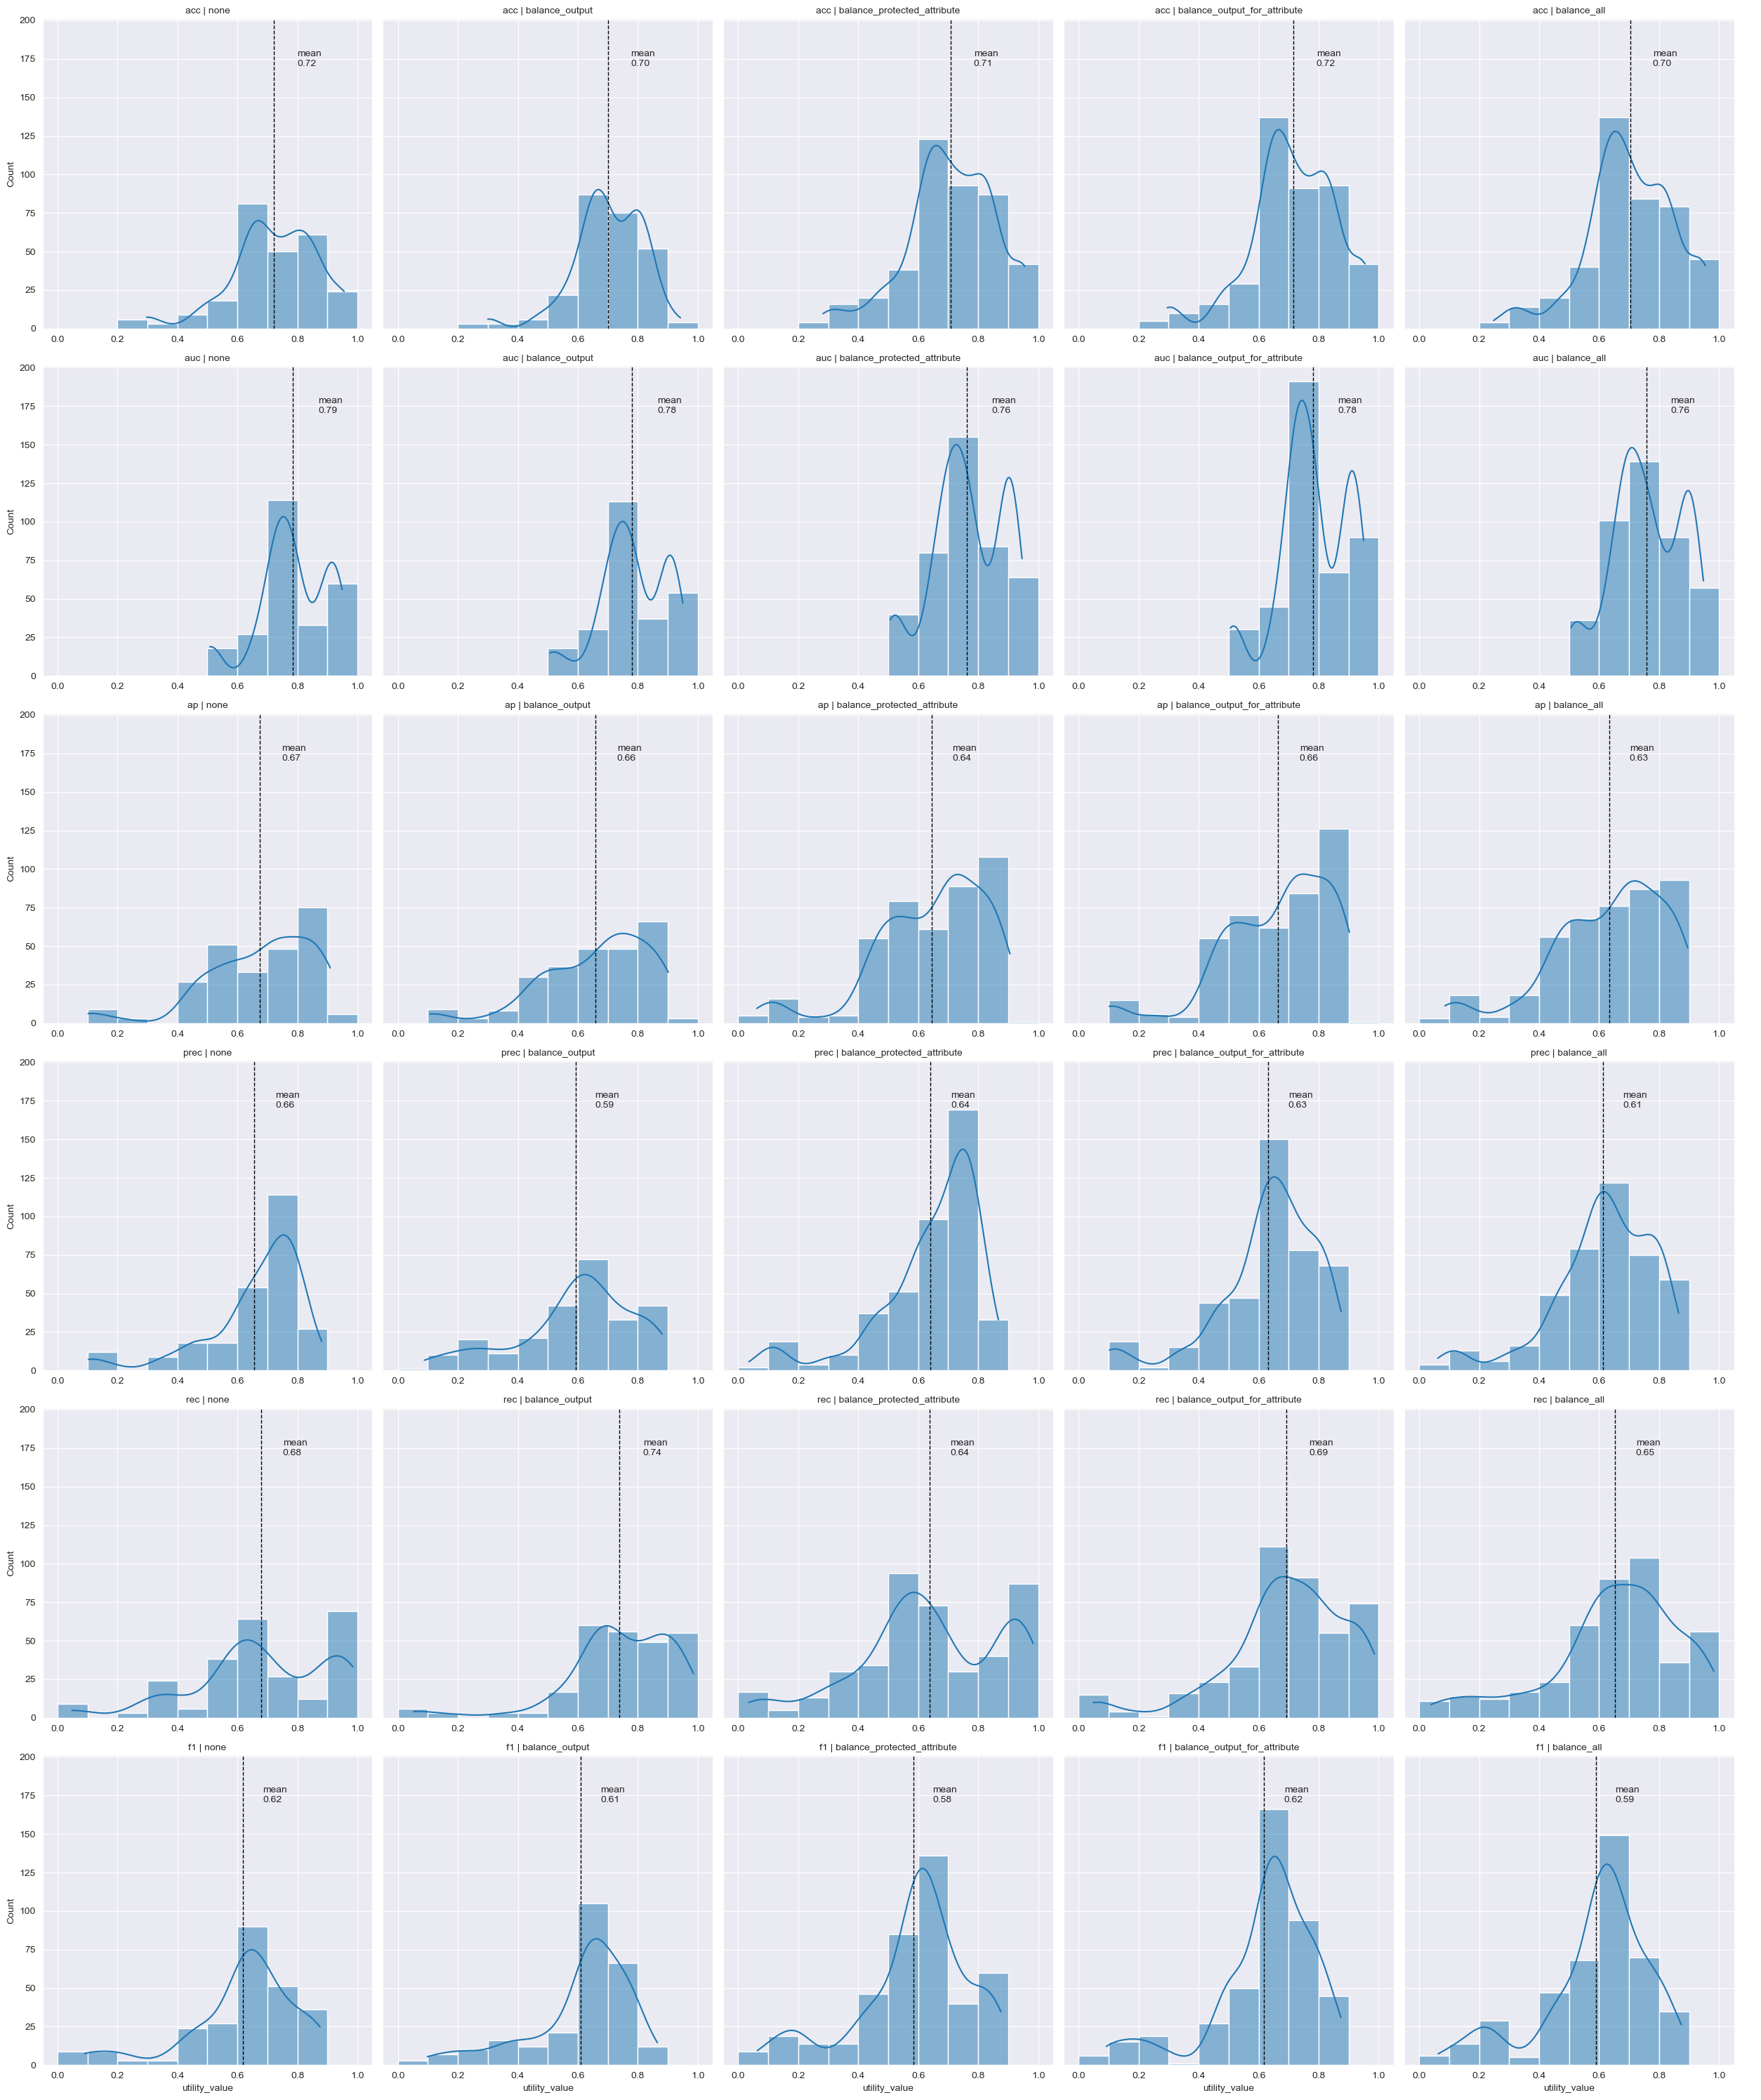

In [39]:
plot_histogram(data=grouped_analysis_melted_utility,
                col_x = "utility_metric",
                col_x_value = "utility_value",
                col_y="mitigation",
                col_y_values = "utility_value",
                col_order = ["none", "balance_output", "balance_protected_attribute", "balance_output_for_attribute", "balance_all"],
                datasets = datasets,
                mitigations = ["none", "balance_output",  "balance_protected_attribute", "balance_output_for_attribute", "balance_all"],
                # hue= "sampling"
                )

# Box Plots

In [41]:
def plot_histogram(data=grouped_analysis_melted_fairness,
                 col_x = "fairness_metric",
                 col_x_value = "fairness_value",
                 col_y="mitigation",
                 col_y_order =  ["none","balance_output", "balance_protected_attribute", "balance_output_for_attribute", "balance_all"],
                 col_order_metrics = ["dpdiff", "eoddsdiff", "miss_rate_ratio", "fall_out_ratio", "dpr", "eoddsr"],
                 datasets = datasets,
                 mitigations = balancing_strategies,
                 hue= None) :
    g = sns.FacetGrid(data[(data["dataset"].isin(datasets))],
                      col=col_x,
                      col_order= col_order_metrics,
                      sharey=True,
                      sharex=True,
                      height=5)
    g.set(xlim=(-0.05,1.05),xticks=np.arange(0,1.1,0.1))
    g.map_dataframe(sns.boxplot,
                    x = col_x_value,
                    y = col_y,
                    order = col_y_order,
                    width = .6,
                    hue = hue
                    )
    g.add_legend()

    return g

c:\Users\lequeup\OneDrive - FUJITSU\Documents\PHASE\Code\.conda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


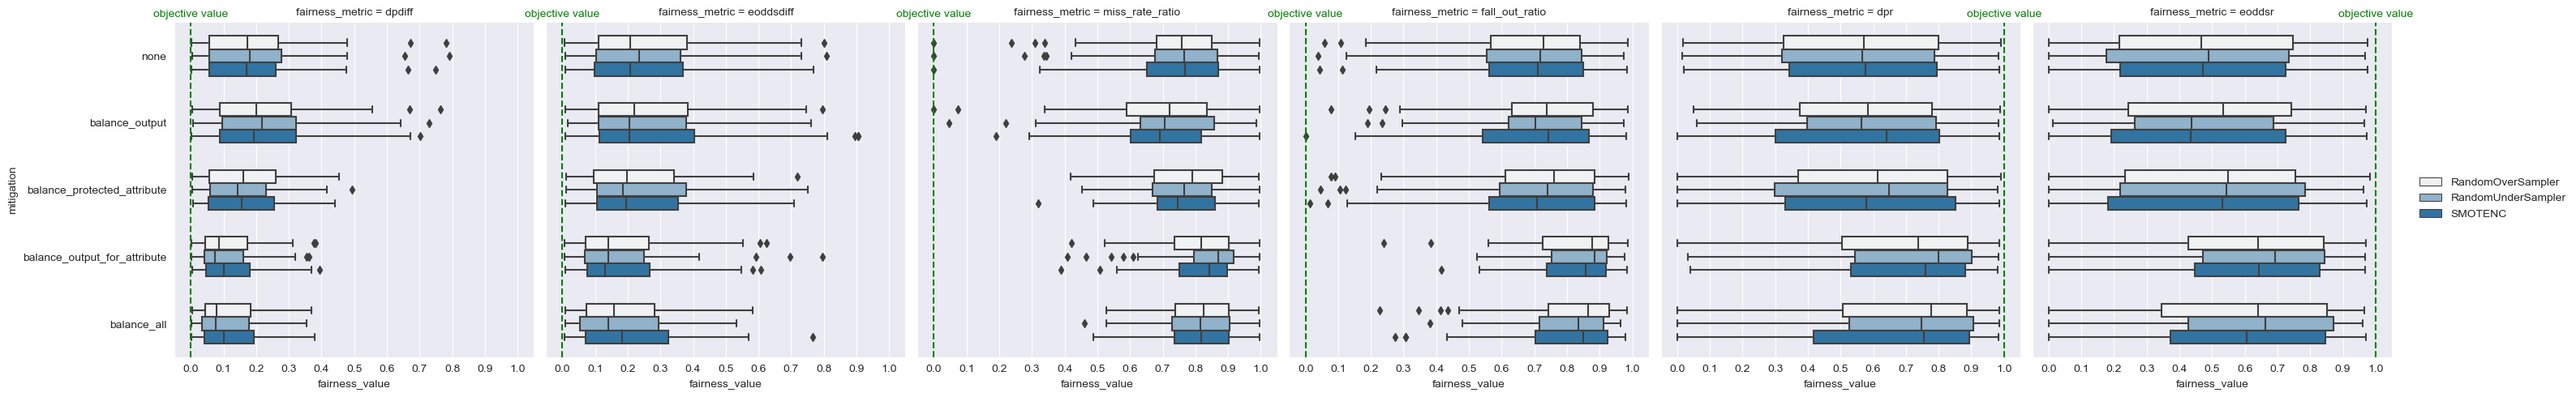

In [42]:
g = plot_histogram(data=grouped_analysis_melted_fairness[(grouped_analysis_melted_fairness["mitigated_attribute"] != "all")
                                                         & (grouped_analysis_melted_fairness["attribute"] != "attribute_3")],
                col_x = "fairness_metric",
                col_x_value = "fairness_value",
                col_y="mitigation",
                col_y_order =  ["none","balance_output", "balance_protected_attribute", "balance_output_for_attribute", "balance_all"],
                col_order_metrics = [
                  "dpdiff", "eoddsdiff", "miss_rate_ratio",
                   "fall_out_ratio", "dpr", "eoddsr"
                                     ],
                datasets = datasets,
                mitigations = balancing_strategies,
                hue= "sampling")

ax = g.axes
for i in range(6) :
  if i <=3 :
    ax[0,i].axvline(x=0, color="green", linestyle='--')
    ax[0,i].text(0, -0.62, 'objective value', c="green" ,va="center", ha="center")
  else :
    ax[0,i].axvline(x=1, color="green", linestyle='--')
    ax[0,i].text(1, -0.62, 'objective value', c="green" ,va="center", ha="center")

c:\Users\lequeup\OneDrive - FUJITSU\Documents\PHASE\Code\.conda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


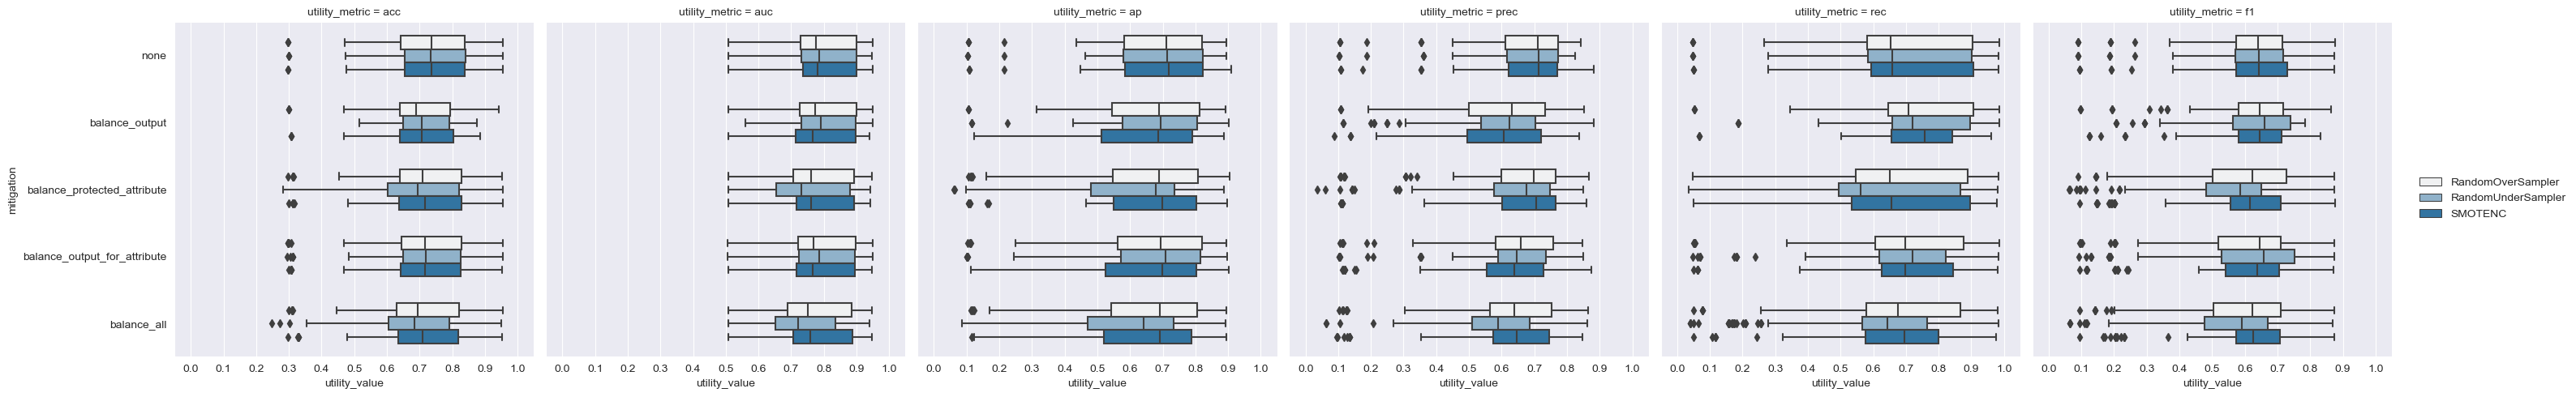

In [43]:
g = plot_histogram(data=grouped_analysis_melted_utility,
                col_x = "utility_metric",
                col_x_value = "utility_value",
                col_y="mitigation",
                col_y_order =  ["none","balance_output", "balance_protected_attribute", "balance_output_for_attribute", "balance_all"],
                col_order_metrics = None,
                datasets = datasets,
                mitigations = balancing_strategies,
                hue= "sampling")

# Correlation Matrix

In [45]:
def correlation_matrix(data = grouped_analysis_df,
                       mitigation = balancing_strategies,
                       x_cols = ["CBS_arithm", 'balance_index', 'RMSDIR', 'RMSPMI'],
                       y_cols = ['dpdiff', 'dpr', 'eoddsdiff', 'eoddsr', 'miss_rate_ratio', 'fall_out_ratio'],
                       abs = True) :
    true_y_col = [el  for el in y_cols if el not in x_cols]
    corr_df = data[data["mitigation"].isin(mitigation)][x_cols + true_y_col].corr().loc[x_cols, y_cols]
    if abs :
        corr_df = corr_df.apply(lambda x : np.abs(x))

    palette = sns.cubehelix_palette(start=0, rot=0, dark=.2, light=1, gamma=1.5, as_cmap=True)
    sns.heatmap(corr_df, annot=True, cmap=palette)

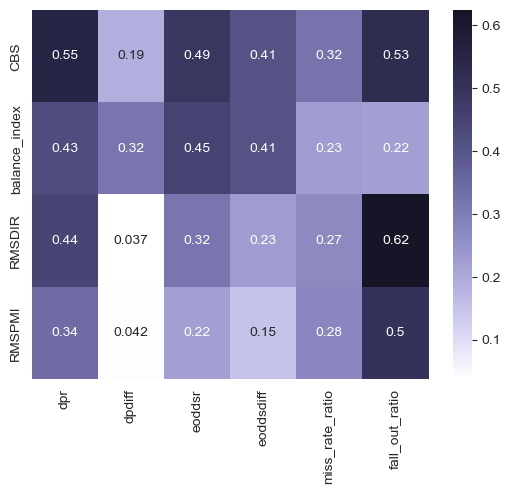

In [46]:
correlation_matrix(data = grouped_analysis_df[grouped_analysis_df["mitigation"] == "none"],
                    mitigation = balancing_strategies,
                    x_cols = ["CBS", 'balance_index', 'RMSDIR', 'RMSPMI'],
                    y_cols = ['dpr', 'dpdiff', 'eoddsr', 'eoddsdiff', 'miss_rate_ratio', 'fall_out_ratio'],
                    abs = True)

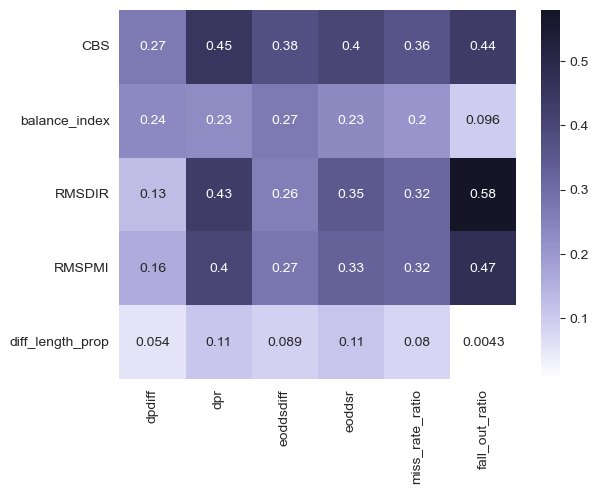

In [47]:
correlation_matrix(data = grouped_analysis_df,
                    mitigation = balancing_strategies,
                    x_cols = ["CBS", 'balance_index', 'RMSDIR', 'RMSPMI', "diff_length_prop"],
                    y_cols = ['dpdiff', 'dpr', 'eoddsdiff', 'eoddsr', 'miss_rate_ratio', 'fall_out_ratio'],
                    abs = True)

In [48]:
correlation_matrix(data = grouped_analysis_df,
                    mitigation = balancing_strategies,
                    x_cols = [ "CBS_arithm2_with_reg", "CBS_arithm2", 'balance_index', 'RMSDIR', 'RMSPMI', "diff_length_prop"],
                    y_cols = [ "CBS_arithm2_with_reg", "CBS_arithm2", 'balance_index', 'RMSDIR', 'RMSPMI', "diff_length_prop"],
                    abs = True)

KeyError: "['CBS_arithm2_with_reg', 'CBS_arithm2'] not in index"

In [ ]:
correlation_matrix(data = grouped_analysis_df,
                    mitigation = balancing_strategies,
                    x_cols = ["CBS_arithm", 'balance_index', 'RMSDIR', 'RMSPMI'],
                    y_cols =  ['acc', 'auc','ap', 'prec', 'rec', 'f1'],
                    abs = True)

In [ ]:
correlation_matrix(data=grouped_analysis_df,
                   x_cols=['balance_index', 'RMSDIR', 'RMSPMI', "CBS_arithm"],
                   y_cols=['balance_index', 'RMSDIR', 'RMSPMI', "CBS_arithm"],
                   abs=True)

In [ ]:
correlation_matrix(data=grouped_analysis_df,
                   x_cols=['balance_index', 'RMSDIR', 'RMSPMI', "CBS_arithm"],
                   y_cols=["acc", "auc", "ap", "prec", "rec", "f1"],
                   abs=True)

In [ ]:
grouped_delta_analysis_df_melted

,model,dataset,sampling,mitigation,mitigated_attribute,attribute,fairness_metric,fairness_variation,CFS,balance_index,RMSDIR,RMSPMI,utility_metric,utility_variation
0,Gaussian,ACS_E,RandomOverSampler,balance_all,all,attribute_1,dpdiff,0.011880,0.097377,0.115417,0.143311,-0.033405,acc,-0.008067
1,Gaussian,ACS_E,RandomOverSampler,balance_all,all,attribute_2,dpdiff,-0.006201,0.268766,0.527182,0.228993,-0.050125,acc,-0.008067
2,Gaussian,ACS_E,RandomOverSampler,balance_all,attribute_1,attribute_1,dpdiff,0.010249,0.097590,0.115417,0.143646,-0.033709,acc,-0.010217
3,Gaussian,ACS_E,RandomOverSampler,balance_all,attribute_2,attribute_2,dpdiff,-0.005398,0.269096,0.527182,0.229600,-0.050506,acc,-0.006183
4,Gaussian,ACS_E,RandomOverSampler,balance_output,none,attribute_1,dpdiff,0.011024,0.023462,0.030226,0.044835,0.004675,acc,-0.007267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,RF,german,SMOTENC,balance_output_for_attribute,attribute_2,attribute_2,fall_out_ratio,0.166845,0.049020,-0.073500,0.151425,-0.069136,f1,0.456237
43088,RF,german,SMOTENC,balance_protected_attribute,all,attribute_1,fall_out_ratio,-0.177101,0.118015,0.392500,-0.020430,0.018024,f1,0.469179
43089,RF,german,SMOTENC,balance_protected_attribute,all,attribute_2,fall_out_ratio,0.221954,0.196791,0.615000,-0.001302,0.023325,f1,0.469179
43090,RF,german,SMOTENC,balance_protected_attribute,attribute_1,attribute_1,fall_out_ratio,-0.211264,0.157238,0.392500,0.053101,-0.026112,f1,0.461134
